# Recurrent Neural Networks (RNNs) in predizioni temporali

**Machine Learning con applicazioni - Matteo Citterio 09494A Settembre 2023**

## Introduzione

In questo progetto studierò l'impiego di reti neurali ricorrenti per la previsione delle variabili metereologiche relative al **vento** dell'aereoporto di Bresso.

I dati sono relativi all'[Aereoporto di Bresso](https://it.wikipedia.org/wiki/Aeroporto_di_Bresso) e raccolti dalla [stazione meteo](https://www.wunderground.com/weather/LIMB) ivi presente. Per scaricare tutti i dati è stato utilizzato un semplice [programma di *scraping*](https://github.com/matteocitterio/ML/blob/main/table_scraper.py) in python che facendo utilizzo della libreria [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) scarica i dati giorno per giorno e li raccoglie poi in un unico dataframe, poi salvato in .csv

## Motivazione

L'aereoporto di Bresso ospita l'omonimo aereoclub che opera principalmente con aereomobili di piccola taglia. Specialmente per questi veicoli (con carrello 'biciclo'), conoscere con discreta precisione le condizioni del vento presenti in pista nelle fasi di decollo e atterraggio è un fattore cruciale per la sicurezza.
Questo semplice lavoro prova quindi a studiare la possibilità di effettuare **predizioni a corto raggio** (5 minuti successivi ai dati rilevati) delle variabili relative al vento utilizzando i dati metereologici dei 60 minuti precedenti alla predizione.

## Dataset

I dati si riferiscono alle variabili meteorologiche misurate all'aereoporto di bresso riportate in seguito:

- Time (hour-min AM/PM YYYY-MM-DD)
- Temperature (°F)
- Dew Point (°F)
- Humidity (%)
- Wind (Direction)
- Speed (mph)
- Gust (mph)
- Pressure (inHg)
- Precip. Rate. (inches)
- Precip. Accum. (inches)
- UV (UV index)
- Solar (W/M^2)

I dati sono rilevati con una frequenza di 5 min e l'intero dataset copre l'arco di tre anni di osservazioni. Si noti che poichè si sono osservati dei valori (nan), il dataset è stato troncato e di riferisce a 2 anni di osservazioni. Per *wind gust* si intendono rapide variazioni nella velocità del vento, solitamente di durata inferiore ai [20 secondi](https://en.wikipedia.org/wiki/Wind_gust). 



Ovviamente il dataset per come scaricato non è pronto ad essere utilizzato come input di una rete neurale. È necessaria una prima fase di data processing dove i dati vengono messi nel formato corretto e processati in modo da renderli i più utili possibili ai fini del progetto. Successivamente si definisce il dataset in termini di datapoint per la rete neurale e il supervised learning ed infine lo si divide in training set, validation set e test set. 

### Visualizzazione dati e processing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import random
from datetime import datetime

import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

Prima di tutto leggo i dati con l'utilizzo di Pandas

In [2]:
path = './data.csv'
df = pd.read_csv(path)
df.dropna(how='any', inplace=True)

Stampo il dataframe per farmi un'idea di come sono fatti i dati:


In [3]:
df.head()

Unnamed: 0                 Time Temperature Dew Point Humidity   Wind  \
0           0  12:04 AM 2022-04-30     59.7 °F   39.9 °F     48 %  North   
1           1  12:09 AM 2022-04-30     59.6 °F   40.1 °F     48 %  North   
2           2  12:14 AM 2022-04-30     59.3 °F   41.0 °F     51 %    NNE   
3           3  12:19 AM 2022-04-30     58.8 °F   41.1 °F     52 %    NNE   
4           4  12:24 AM 2022-04-30     59.1 °F   41.2 °F     51 %    NNE   

     Speed     Gust  Pressure Precip. Rate. Precip. Accum.   UV    Solar  
0  0.2 mph  0.3 mph  30.09 in       0.00 in        0.00 in  0.0  0 w/m²   
1  0.1 mph  0.3 mph  30.09 in       0.00 in        0.00 in  0.0  0 w/m²   
2  0.9 mph  1.3 mph  30.09 in       0.00 in        0.00 in  0.0  0 w/m²   
3  1.4 mph  1.8 mph  30.09 in       0.00 in        0.00 in  0.0  0 w/m²   
4  1.1 mph  1.6 mph  30.09 in       0.00 in        0.00 in  0.0  0 w/m²

Anzichè una versione letterale della direzione del vento mi conviene convertirla in un valore numerico.
Prima uniformo il modo in cui sono scritte le direzioni dei venti:

In [4]:
Written_winds = ['North', 'South', 'East', 'West']
Shorter_winds = ['N', 'S', 'E', 'W']

df.Wind = df.Wind.replace(Written_winds, Shorter_winds)

Poi converto in gradi `[°]` la direzione del vento utilizzando la funzione che ho scritto, assicurandomi che il mapping tra direzioni e angoli sia corretto:

In [5]:
wind_dirs = ['N', 'NNE', 'NNW', 'NW', 'NE', 'ENE', 'E', 'SE',
             'ESE', 'SSE', 'WNW', 'W', 'S', 'SW', 'SSW', 'WSW']
angle_list = [0, 22.5, 337.5, 315, 45, 67.5, 90, 135,
              112.5, 157.5, 295.5, 270, 180, 225, 202.5, 247.5]


In [6]:
def direction_to_angle(direction, wind_dirs, angle_list):
    """
    It takes a direction (str) and outputs a direction (float) in terms of degrees
    """
    list_wind = []
    for i in range(0, len(direction)):
        index = wind_dirs.index(direction.iloc[i])
        list_wind.append(angle_list[index])
    return list_wind

df.Wind = direction_to_angle(df.Wind, wind_dirs, angle_list)

Ora tolgo le stringhe delle unità di misura all'interno dei dati che lo richiedono e converto tutto in float:

In [7]:
head_list = [
    'Temperature',
    'Humidity',
    'Dew Point',
    'Speed',
    'Gust',
    'Pressure',
    'Precip. Rate.',
    'Precip. Accum.',
    'Solar',
]

for header in head_list:
    df[header] = (df[header].str.split().str[0])
    df[header] = (df[header].astype(float))

Un'altra cosa intelligente che possiamo fare è trasformare la coppia di informazioni `(wind speed, wind direction)` in `(windx, windy)` ovvero trasformare il modulo e direzione di un vettore nelle sue due componenti cartesiane, fare cioè la trasformazione tra coordinate radiali a cartesiane:

In [8]:
wv = df.pop('Speed')

# Convert to radians.
wd_rad = df.pop('Wind')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

Posso quindi visualizzare la direzione e la velocità del vento con un istogramma bidimensionale:

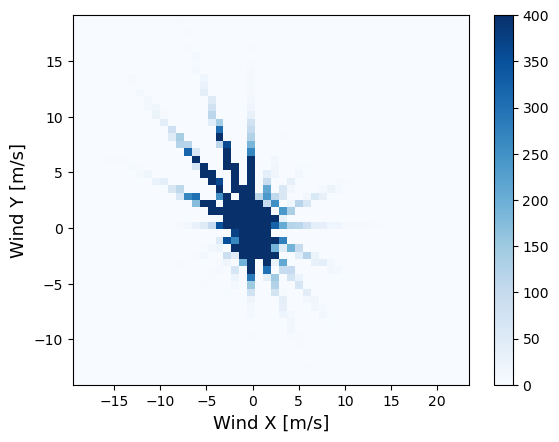

In [9]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400, cmap='Blues')
plt.colorbar()
plt.xlabel('Wind X [m/s]', fontsize=13)
plt.ylabel('Wind Y [m/s]', fontsize=13)
ax = plt.gca()
ax.axis('tight')

plt.show()

Si noti come vi è una leggera prevalenza nella direzione del vento dettata dalla particolare posizione dell'aereoporto e dalle condizioni climatiche del luogo

Anche la colonna `Time` è ovviamente importante ma se espressa in secondi o in formato letterale non ha una grande utilità. Ovviamente poichè si stanno trattando dati meteorologici, ci aspettiamo una certa periodicità sia su base annuale che su base giornaliera. Un'idea intelligente può essere allora trasformare la data in un 'segnale' periodico con periodo annuo e giornaliero:

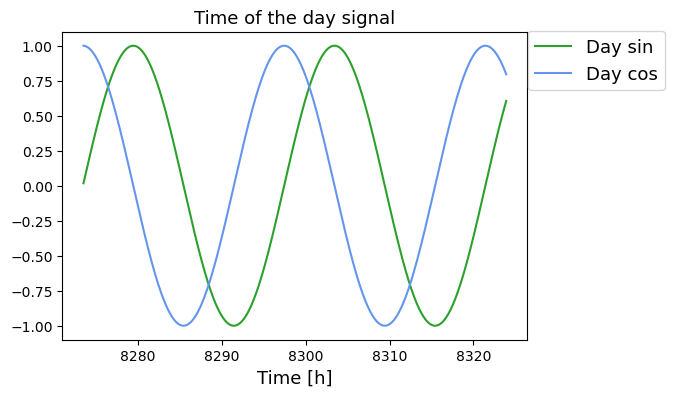

In [10]:
date_time = pd.to_datetime(df.pop('Time'), format='%I:%M %p %Y-%m-%d')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day
hour = 60 * 60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df['Hour'] = (timestamp_s - min(timestamp_s)) / hour

fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.plot(np.array(df['Hour'])[:576],np.array(df['Day sin'])[:576], label='Day sin', color='tab:green')
ax2.plot(np.array(df['Hour'])[:576],np.array(df['Day cos'])[:576], label= 'Day cos', color='cornflowerblue')
ax2.set_xlabel('Time [h]', fontsize=13)
ax2.set_title('Time of the day signal', fontsize=13)
plt.legend(loc=(1.001,0.81), fontsize=13)
plt.show()

In [11]:
sorted_df = df.sort_values(by='Hour')
sorted_df
sorted_df.pop('Unnamed: 0')
df = sorted_df.iloc[3928:179015]

Si noti come (`df = sorted_df.iloc[3928:179015]`) il dataframe è stato ristretto ad un intervallo temporale dove i dati sono stati presi in maniera continua onde evitare di creare *datapoints* di allenamento sconnessi a livello temporale. Come precedentemente anticipato, in tutto il dataset si riferisce a due anni di osservazioni.
A questo punto i dati sono 'pronti' e posso cercare di capire come meglio utilizzarli. Per rendermi conto del loro ruolo all'interno del dataset ho stampato una matrice di correlazione:

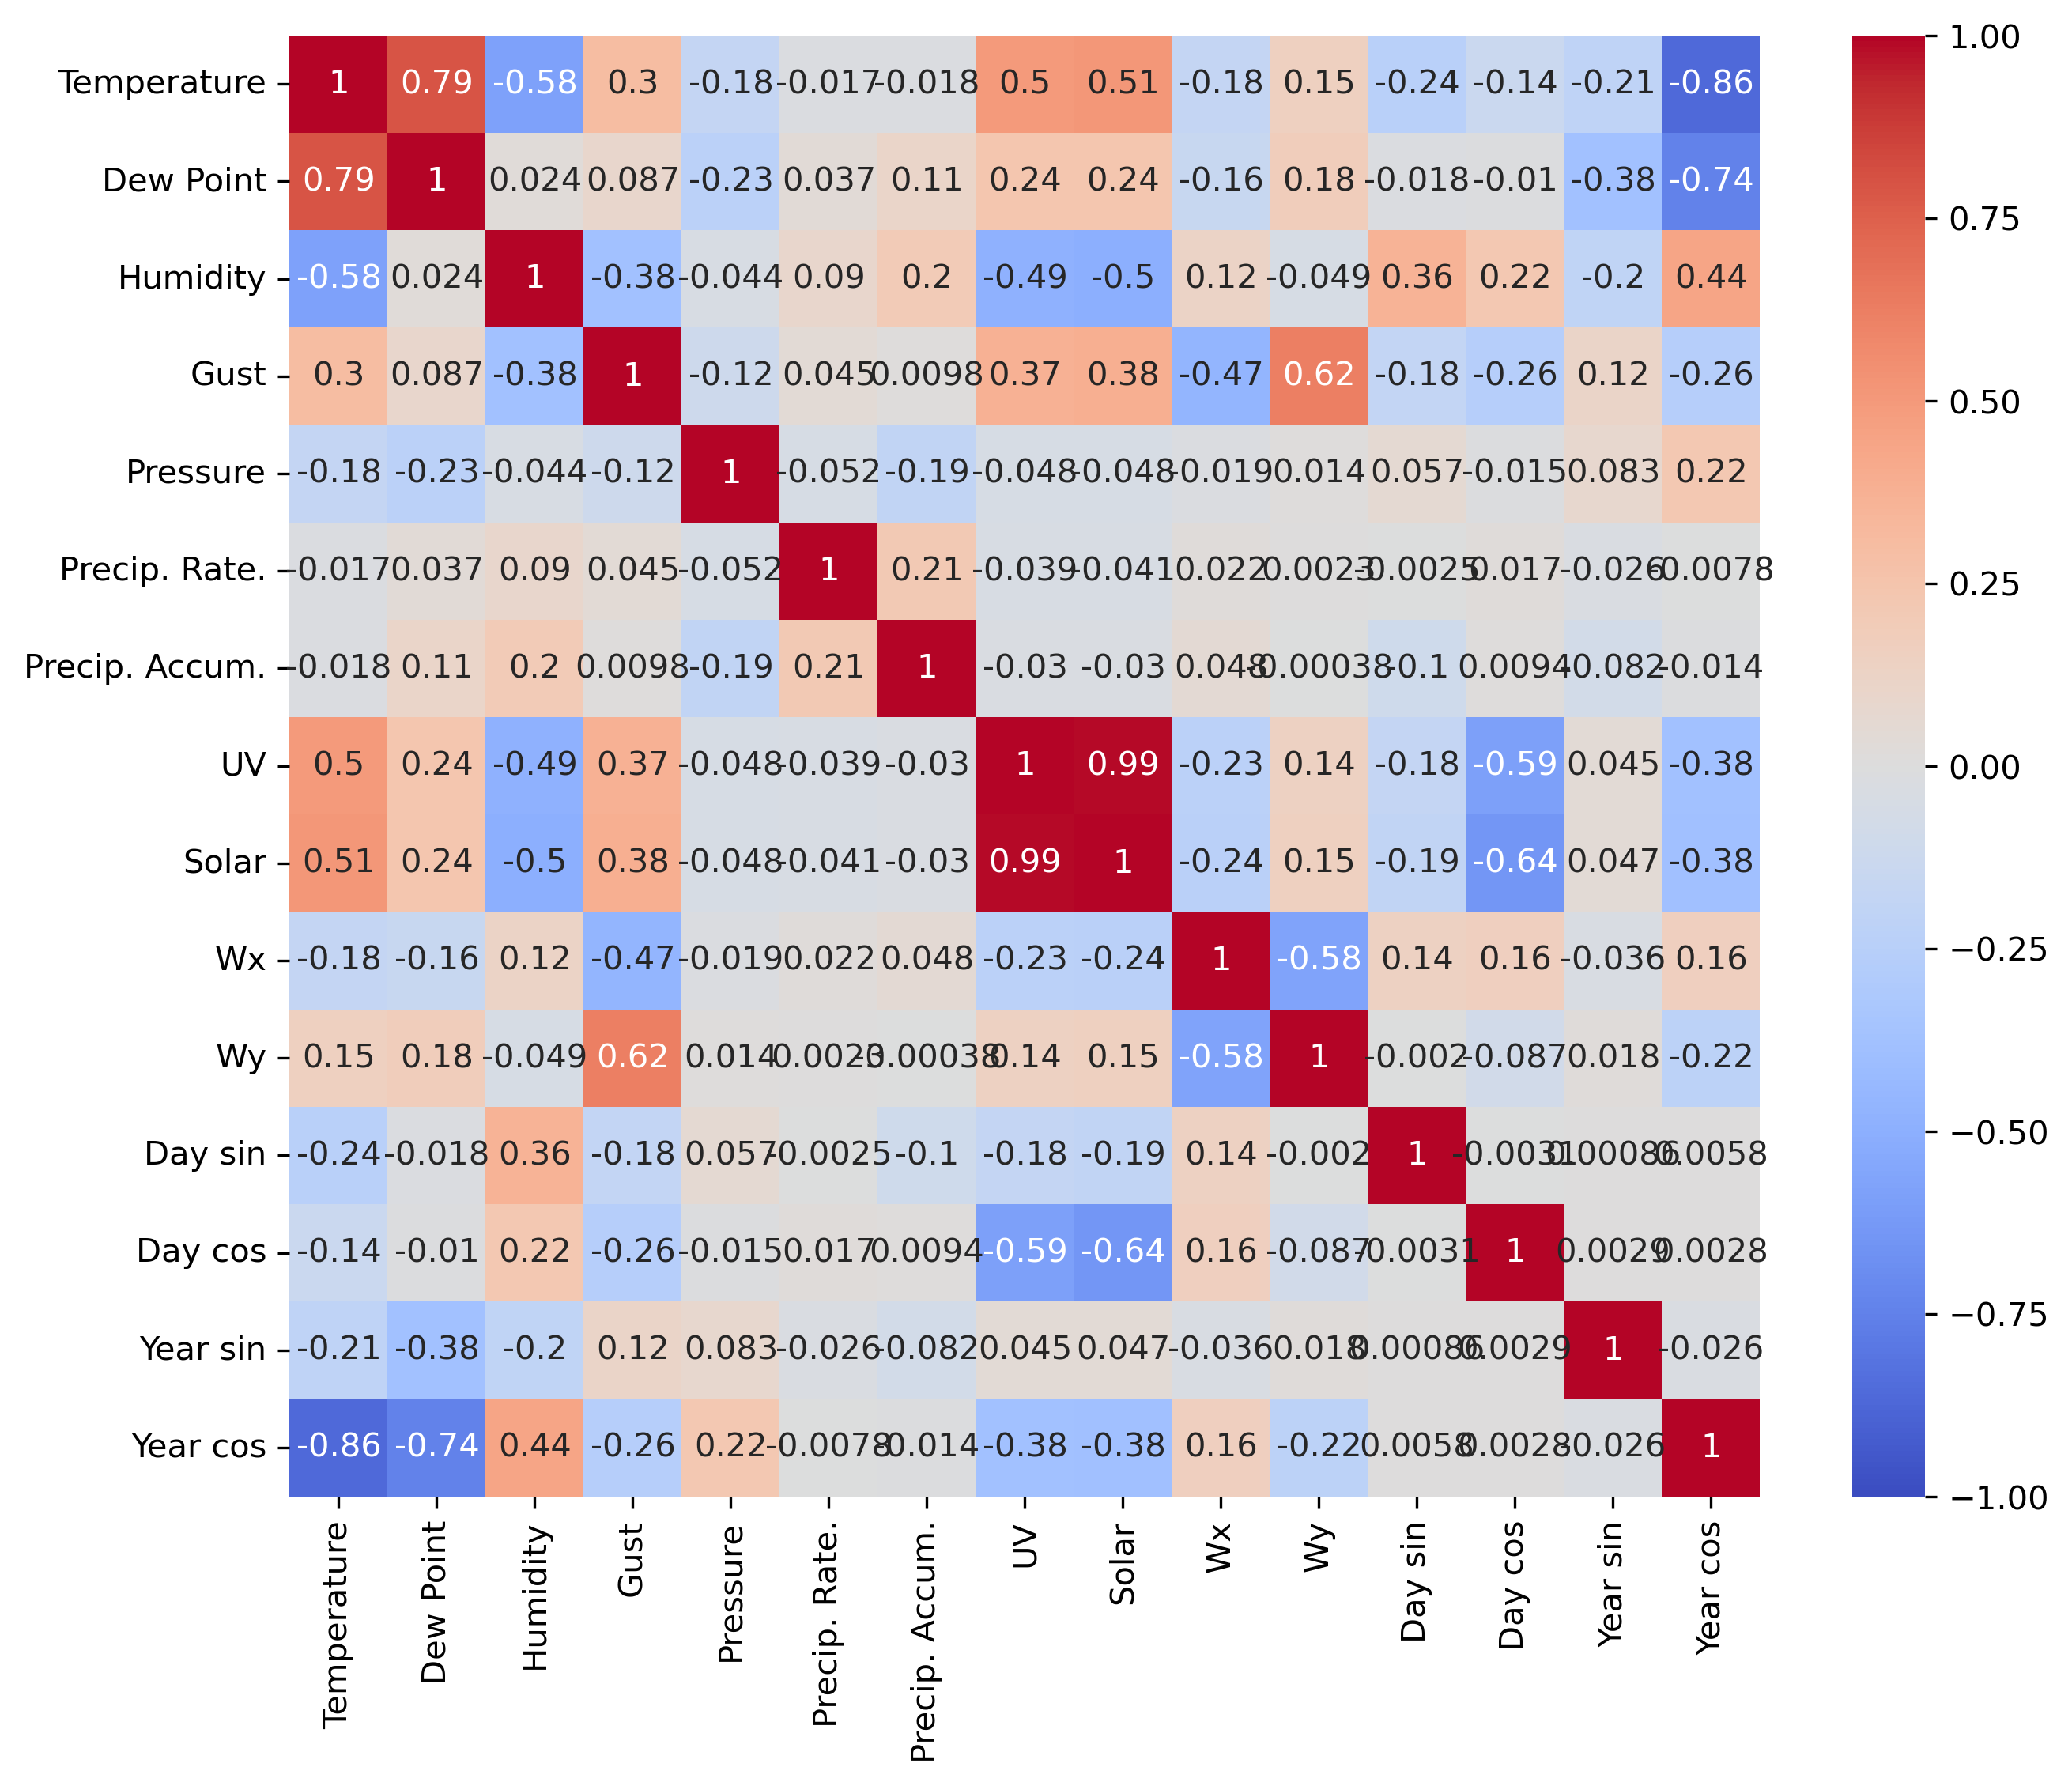

In [12]:
fig3, ax3 = plt.subplots(figsize=(10, 8), dpi = 300)
ax3 = sns.heatmap(df.drop('Hour', axis=1).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

Come mostrato nella seguente figura, la variabile relativa alla frequenza di precipitazione, che non correla molto con gli altri predittori, si presenta come segnali deltiformi che sono stati di difficile utilizzo per il modello. Per questo motivo ho deciso di estrometterla dal dataset.

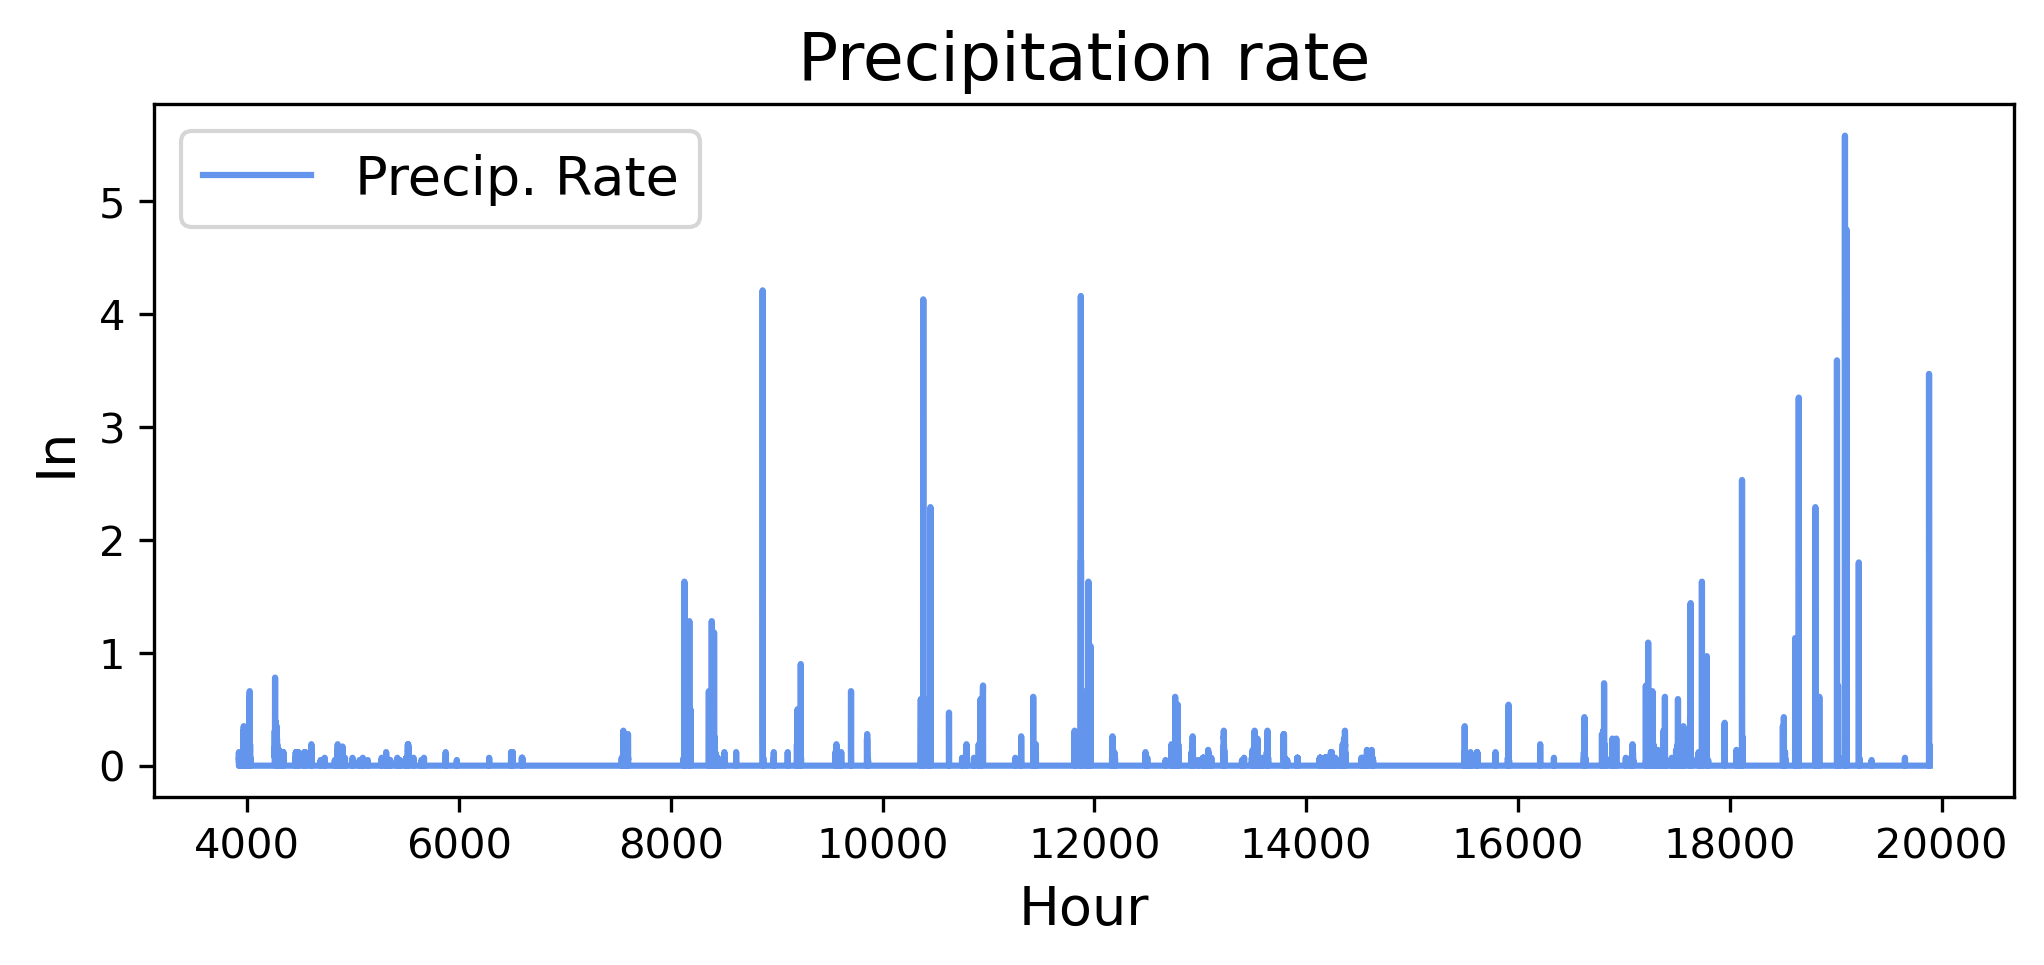

In [13]:
fig = plt.figure(figsize=(8,3), dpi=300)
plt.plot(df['Hour'],df['Precip. Rate.'], color='cornflowerblue', label='Precip. Rate')
plt.legend(fontsize=13)
plt.ylabel('In', fontsize=13)
plt.xlabel('Hour', fontsize=13)
plt.title('Precipitation rate', fontsize=16)
plt.show()

In [14]:
df.pop('Precip. Rate.')
df

Temperature  Dew Point  Humidity  Gust  Pressure  Precip. Accum.   UV  \
140928         52.7       50.2      91.0   0.0     29.99            0.03  0.0   
140929         52.7       50.3      91.0   0.0     29.99            0.03  0.0   
140930         52.7       50.0      91.0   0.0     29.99            0.04  0.0   
140931         52.6       49.9      90.0   0.0     29.99            0.04  0.0   
140932         52.7       50.0      91.0   0.0     29.99            0.05  0.0   
...             ...        ...       ...   ...       ...             ...  ...   
137414         75.2       72.0      89.0   0.6     29.72            0.76  0.0   
137415         75.1       72.3      91.0   0.4     29.73            0.76  0.0   
137416         74.8       72.3      91.0   0.0     29.73            0.76  0.0   
137417         74.8       72.5      92.0   0.0     29.72            0.76  0.0   
137418         74.8       72.5      93.0   0.6     29.73            0.76  0.0   

        Solar            Wx   Wy   Day sin   Day cos  Year sin  Year cos  \
140928   28.6  0.000000e+00 -0.0 -0.913545 -0.406737 -0.874939  0.484232   
140929   31.2  0.000000e+00 -0.0 -0.922201 -0.386711 -0.874910  0.484285   
140930   31.2  0.000000e+00 -0.0 -0.930418 -0.366501 -0.874882  0.484337   
140931   30.3  0.000000e+00 -0.0 -0.938191 -0.346117 -0.874853  0.484389   
140932   29.0  0.000000e+00 -0.0 -0.945519 -0.325568 -0.874824  0.484441   
...       ...           ...  ...       ...       ...       ...       ...   
137414    0.0  1.836970e-17  0.3 -0.241922  0.970296 -0.816046 -0.577987   
137415    0.0  1.224647e-17  0.2 -0.220697  0.975342 -0.816081 -0.577938   
137416    0.0  0.000000e+00  0.0 -0.199368  0.979925 -0.816115 -0.577889   
137417    0.0  0.000000e+00  0.0 -0.177944  0.984041 -0.816150 -0.577841   
137418    0.0  3.061617e-17  0.5 -0.160743  0.986996 -0.816177 -0.577802   

                Hour  
140928   3921.833333  
140929   3921.916667  
140930   3922.000000  
140931   3922.083333  
140932   3922.166667  
...              ...  
137414  19888.500000  
137415  19888.583333  
137416  19888.666667  
137417  19888.750000  
137418  19888.816667  

[175087 rows x 15 columns]

In tutto quindi le quantità utilizzate nell'allenamento sono le seguenti:

In [15]:
features=[
    'Temperature',
     'Dew Point',
     'Humidity',
     'Gust',
     'Pressure',
     'Precip. Accum.',
     'UV',
     'Solar',
     'Wx',
     'Wy',
     'Day sin',
     'Day cos',
     'Year sin',
     'Year cos']

measure_units = [
    '°F',
    '°F',
    '%',
    'mph',
    'inHg',
    'inches',
    '',
    '$W/m^2$',
    '',
    '',
    '',
    '',
    '',
    '']

Che possono essere mostrare in maniera sintetica come nella figura successiva:

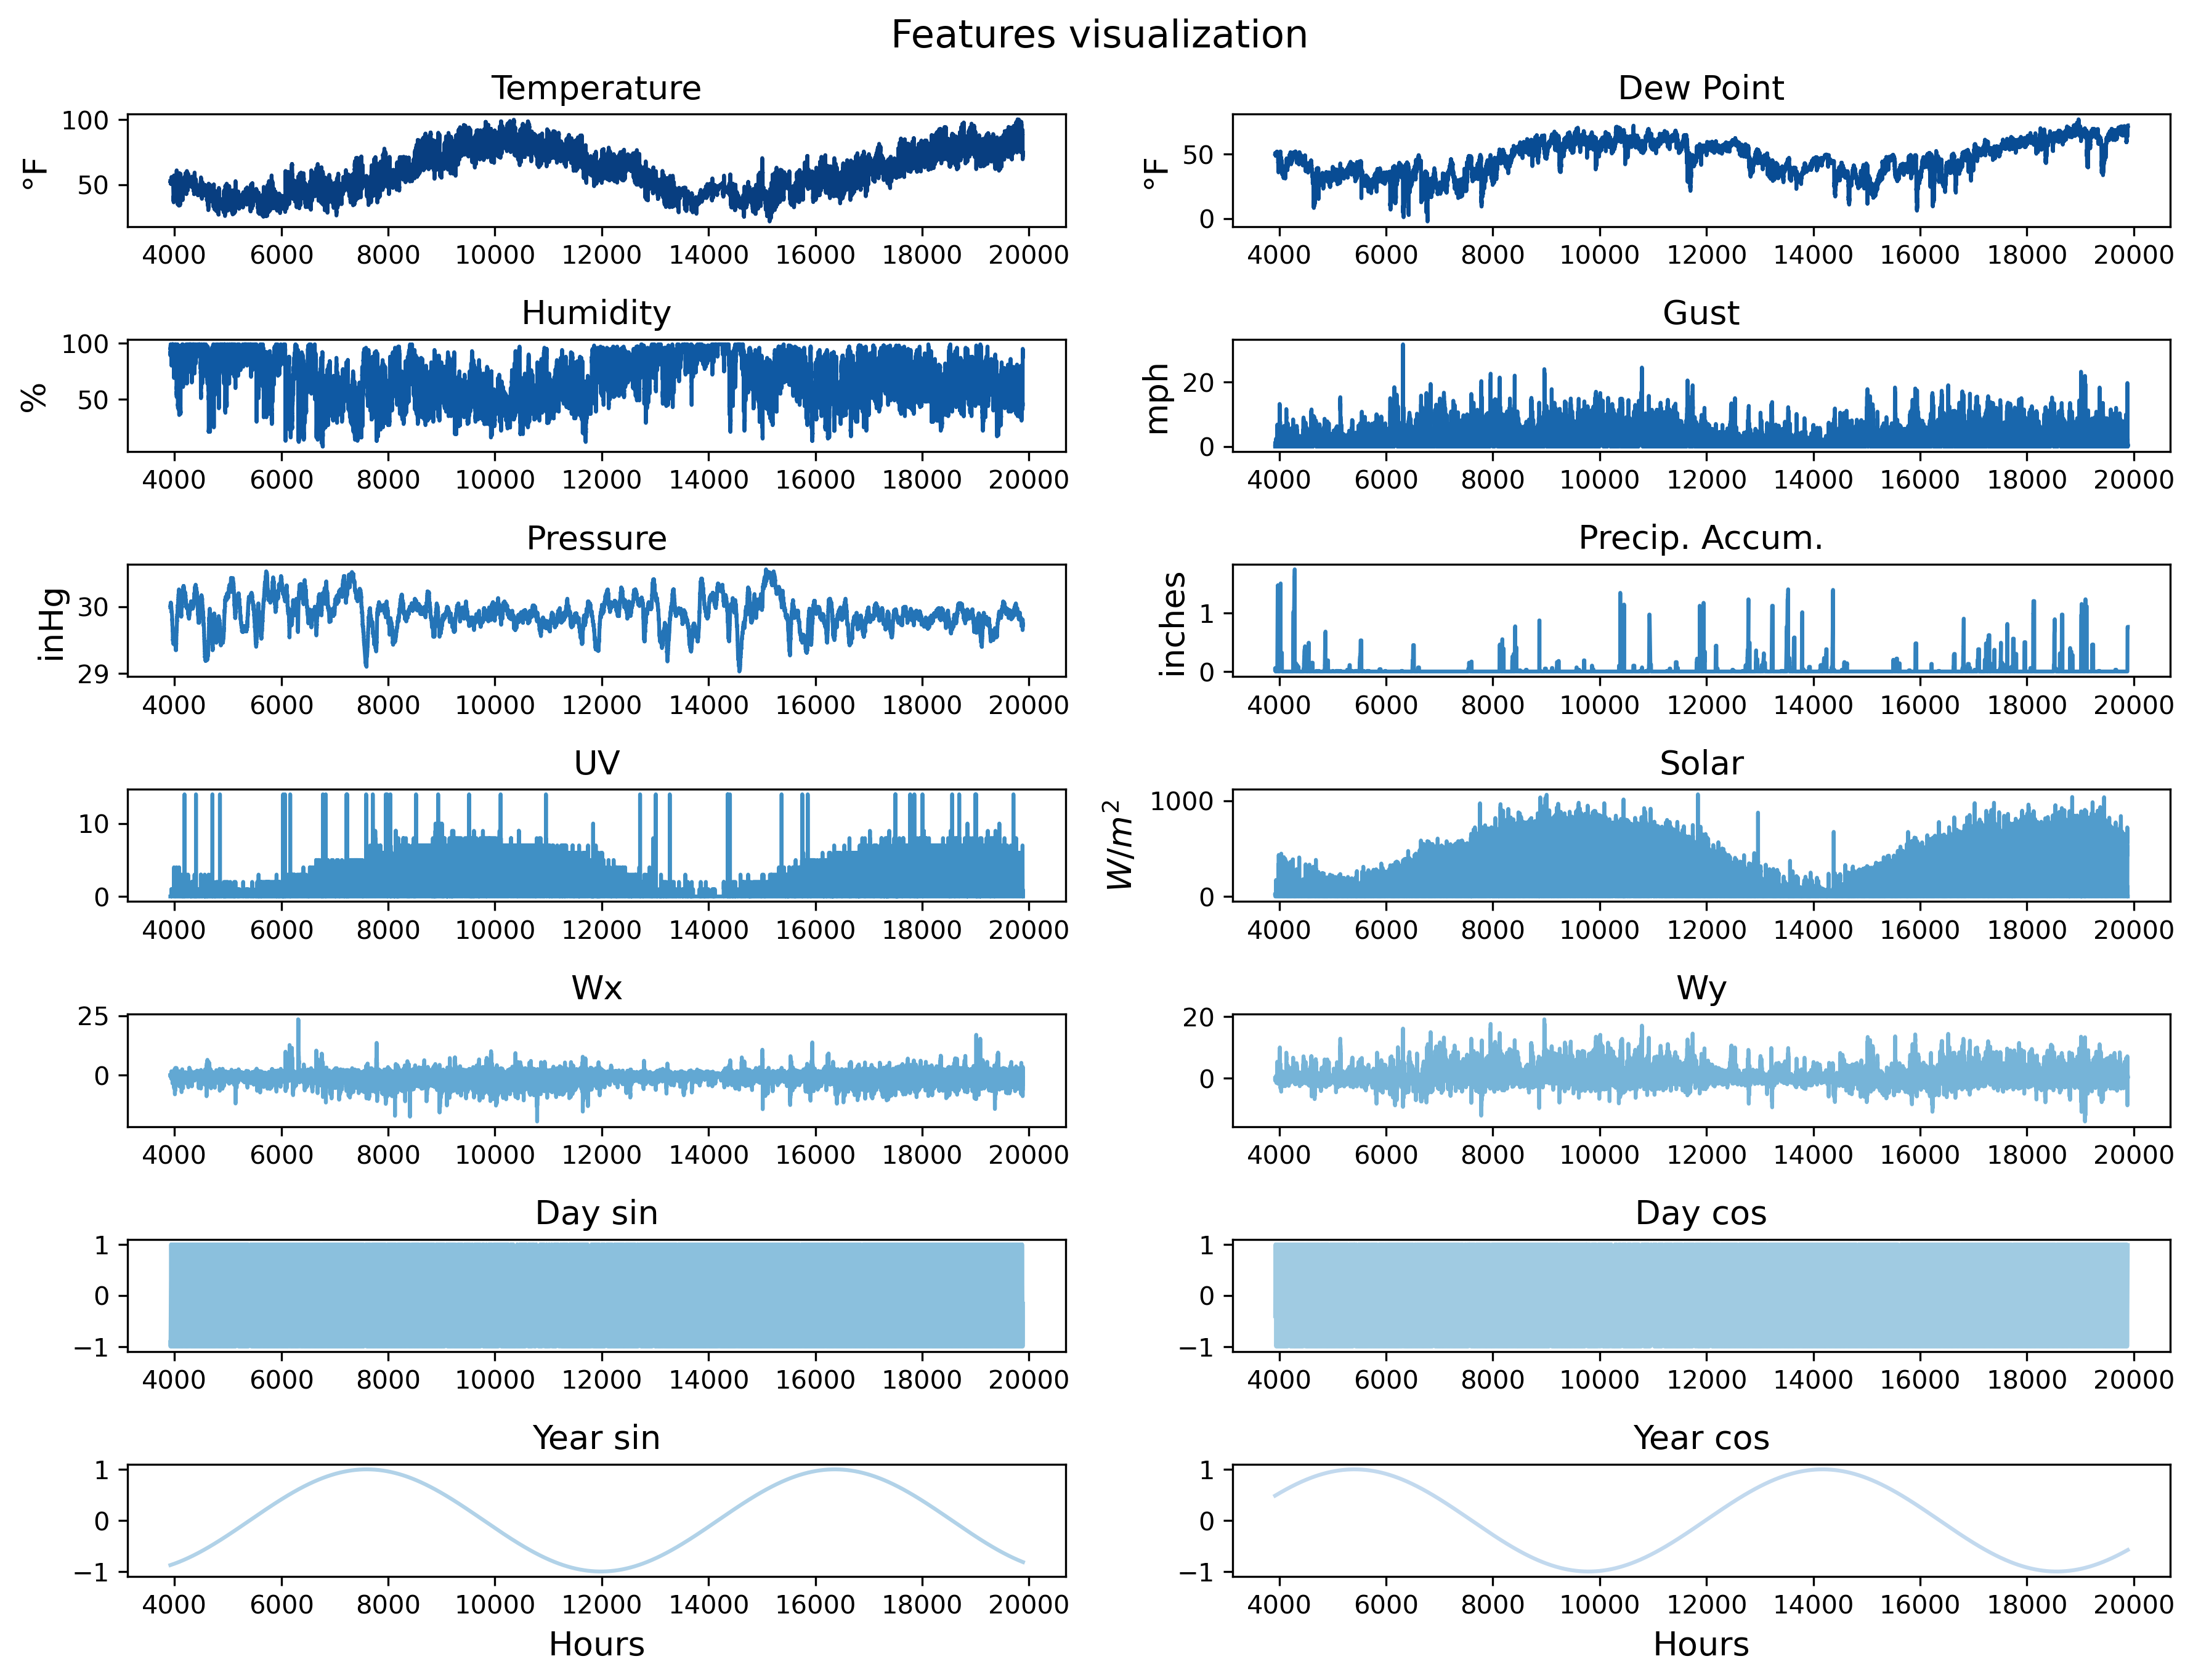

In [16]:
import matplotlib.cm as cm 

original_cmap = cm.get_cmap('Blues')

# Define the index from which you want to start the truncated colormap
start_color_index = 2  # Adjust this index as needed

# Create a function to truncate the colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=20):
    new_cmap = plt.get_cmap(cmap.name + '_r', n)
    new_cmap_colors = cmap(np.linspace(minval, maxval, n))
    new_cmap.colors = new_cmap_colors
    return new_cmap

# Create a truncated colormap
cmap = truncate_colormap(original_cmap, start_color_index / (len(df.columns) - 1))

fig = plt.figure(figsize=(12, 10), dpi=300)

h = 1

for feature in features:
    plt.subplot(8,2,h)
    plt.plot(df['Hour'], df[feature], color=cmap(h))
    plt.title(feature, fontsize=13)
    plt.ylabel(measure_units[h-1], fontsize=13)
    h +=1

plt.subplot(8,2,14)
plt.xlabel('Hours', fontsize=13)

plt.subplot(8,2,13)
plt.xlabel('Hours', fontsize=13)

fig.suptitle('Features visualization', fontsize=15)

plt.tight_layout()
plt.show()

Dai precedenti grafici si rende evidente come alcune variabili esibiscono un andamento *Stagionale*, altre invece sembrano essere più rumorose. In generale la scelta di convertire la data in variabili periodiche è motivata dalla semplice assunzioni a priori di poter descrivere queste variabili come periodo dell'anno (*Year*) + periodo del giorno (*Day*) + fluttuazioni.
Le variabili che ci si pone di predire ['Wx', 'Wy', 'Gust'] non sembrano mostrare un'andamento marcatamente dipendente dalla stagionalità ma anzi si presentano come piuttosto rumorose. Vedremo che nonostante ciò i modelli sono stati in grado di predirle.

## Definizione dataset

Per rendere le variabili tra loro comparabili come predittori e per far sì che l'allenamento della rete non sbilanci i pesi nei confronti di una sola di queste, è necessario **normalizzare** i dati $\in[0,1]$. Un modo semplice per farlo è utilizzare il metodo `preprocessing.MinMaxScaler` della libreria `ScikitLearn` che permette in maniera veloce di effettuare l'operazione inversa una volta ottenute le predizioni.

In [17]:
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning

scaler = MinMaxScaler()

df[features] = scaler.fit_transform(df[features])

df

Temperature  Dew Point  Humidity      Gust  Pressure  Precip. Accum.  \
140928     0.396178   0.660377  0.912088  0.000000  0.627451        0.017241   
140929     0.396178   0.661635  0.912088  0.000000  0.627451        0.017241   
140930     0.396178   0.657862  0.912088  0.000000  0.627451        0.022989   
140931     0.394904   0.656604  0.901099  0.000000  0.627451        0.022989   
140932     0.396178   0.657862  0.912088  0.000000  0.627451        0.028736   
...             ...        ...       ...       ...       ...             ...   
137414     0.682803   0.934591  0.890110  0.018927  0.450980        0.436782   
137415     0.681529   0.938365  0.912088  0.012618  0.457516        0.436782   
137416     0.677707   0.938365  0.912088  0.000000  0.457516        0.436782   
137417     0.677707   0.940881  0.923077  0.000000  0.450980        0.436782   
137418     0.677707   0.940881  0.934066  0.018927  0.457516        0.436782   

         UV     Solar       Wx        Wy   Day sin   Day cos  Year sin  \
140928  0.0  0.026812  0.45341  0.424047  0.043223  0.296630  0.062530   
140929  0.0  0.029249  0.45341  0.424047  0.038895  0.306643  0.062545   
140930  0.0  0.029249  0.45341  0.424047  0.034787  0.316748  0.062559   
140931  0.0  0.028405  0.45341  0.424047  0.030900  0.326940  0.062574   
140932  0.0  0.027187  0.45341  0.424047  0.027236  0.337214  0.062588   
...     ...       ...      ...       ...       ...       ...       ...   
137414  0.0  0.000000  0.45341  0.433082  0.379038  0.985152  0.091977   
137415  0.0  0.000000  0.45341  0.430070  0.389650  0.987676  0.091960   
137416  0.0  0.000000  0.45341  0.424047  0.400315  0.989967  0.091942   
137417  0.0  0.000000  0.45341  0.424047  0.411027  0.992025  0.091925   
137418  0.0  0.000000  0.45341  0.439105  0.419628  0.993503  0.091911   

        Year cos          Hour  
140928  0.742116   3921.833333  
140929  0.742142   3921.916667  
140930  0.742168   3922.000000  
140931  0.742195   3922.083333  
140932  0.742221   3922.166667  
...          ...           ...  
137414  0.211007  19888.500000  
137415  0.211031  19888.583333  
137416  0.211055  19888.666667  
137417  0.211080  19888.750000  
137418  0.211099  19888.816667  

[175087 rows x 15 columns]

Per seconda cosa è necessario decidere come utilizzare questi dati. L'idea del progetto è utilizzare una sequenza di variabili metereologiche piuttosto breve per effettuare una predizione a corto raggio (i 5 minuti successivi) delle variabili di interesse. Tuttavia, andrebbe fatto uno studio, o una `Hyperoptimization` per capire qual'è la lunghezza della sequenza che permette di avere le predizioni ottimali.

Per quanto riguarda l'allenamento del modello ho scelto di identificare una sequenza temporale di lunghezza T ed utilizzare i dati in T+1 come ground thruth o label da confrontare con la predizione. Si tratta quindi di *one point prediction*, ovvero una predizione in un solo istante di tempo futuro, non di una intera sequenza.




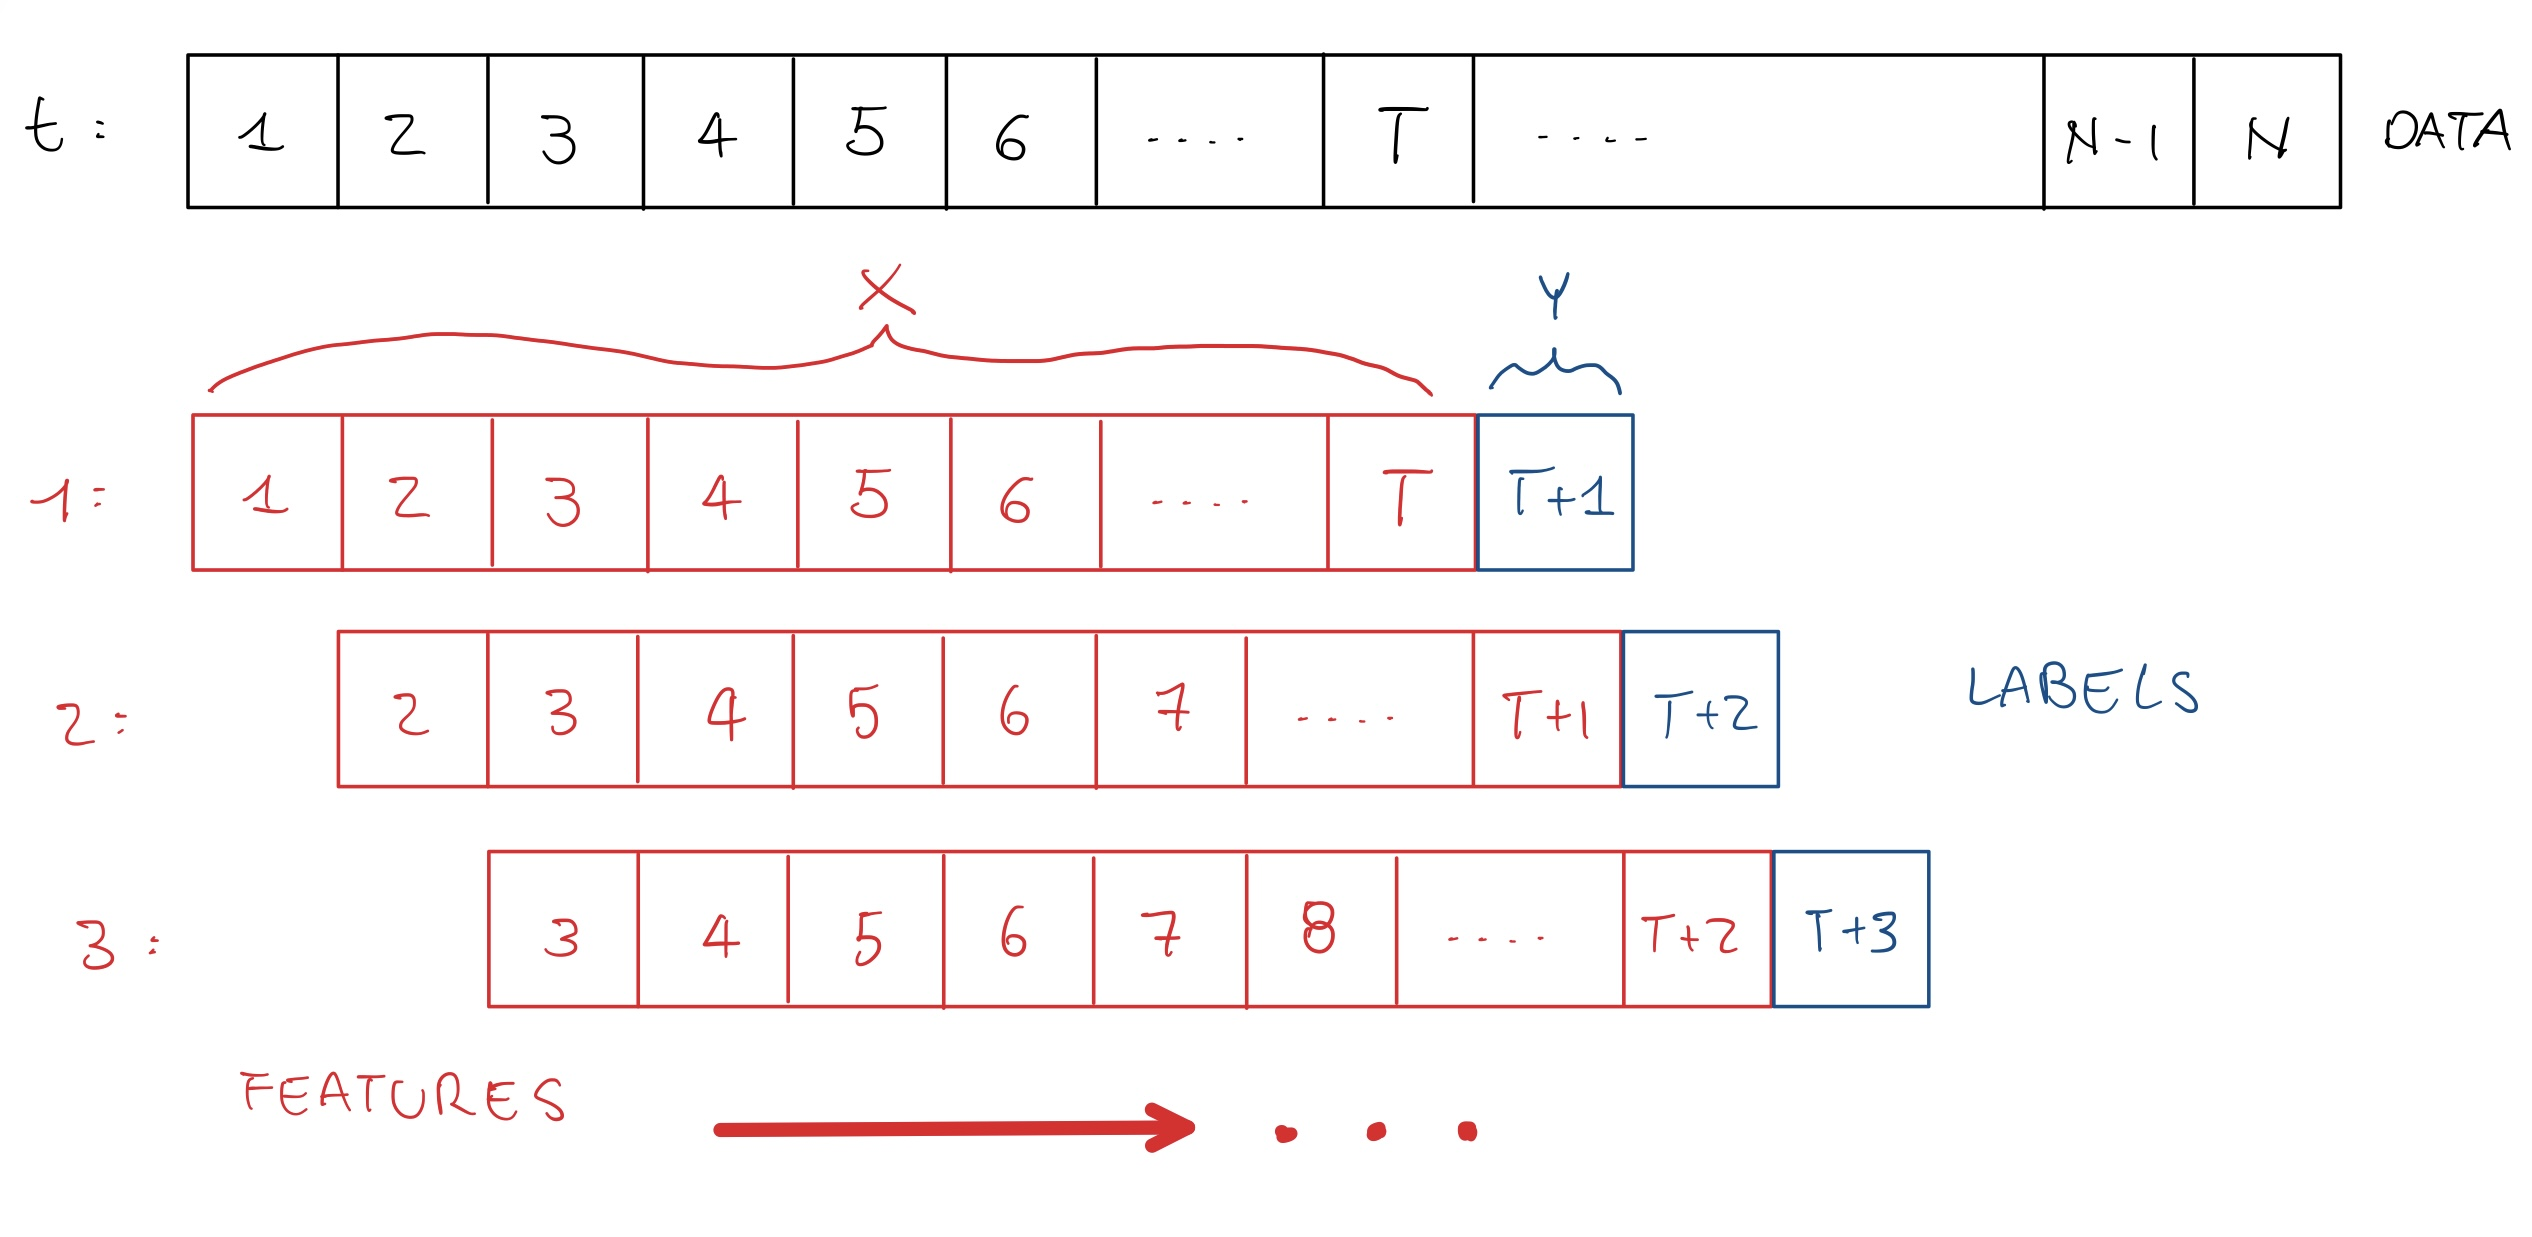

In [18]:
from IPython.display import Image

image_path = 'IMG_1009.jpg'  

Image(filename=image_path)

Come si intuisce dall'immagine, per ottenere i singoli datapoint le le sequenze di lunghezza T vengono shiftate di una lunghezza fino all'esaurimento del dataset.
In questo modo un singolo data point ha shape `(features_shape=(12,14),labels_shape=(1,1))`
É importante osservare che ho deciso di predire una alla volta le variabili di mio interesse tale che l'output dei modelli che utilizzerò ha appunto shape (1,1). Questo perchè empiricamente ho ottenuto risultati migliori in tempi più brevi allenando un modello per ogni variabile anzichè progettarne uno eventualmente più grosso per predirle tutte e tre contemporaneamente. Ciò non toglie che questo sia comunque possibile.

Si è deciso di utilizzare `T=60 min` che corrisponde a `12 rilevazioni` all'interno del dataset (la frequenza rilevazione è di 1 rilevazione/5 min). Questo perchè si è osservato essere un buon compromesso tra la durata del training e la qualità di predizione dei modelli.

Divido il dataset in 70% train, 20% validation e 10% test, togliendo dagli effettivi dati la colonna delle ore che userò solo per le visualizzazioni grafiche.

In [19]:
Hour = df.pop('Hour')

In [20]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):int(n*1)]

In [21]:
print(f'Lunghezza del training dataframe: {len(train_df)} dati')

Lunghezza del training dataframe: 122560 dati


Successivamente ho deciso di implementare una classe che si occupasse del data handling, in primo luogo dello `windowing` che è stato appena descritto. Ho deciso di utilizzare il maggior numero di primitive di `Tensorflow` possibili per gestire i dati, al costo di perdere un po' di leggibilità ma aumentando di gran lunga l'efficienza.
Il seguente codice (commentato in dettaglio) contiene i metodi:
```Python

class WindowGenerator():
    
    def __init__(...):
        
        """Inizializza la classe ed i suoi data membri"""
    def __repr__(...):
        """ritorna output a terminale quando la classe viene creata, utile solo per la leggibilità del codice"""
    def split_window(...):
        """ Metodo che effettivamente si occupa di dividere i dati in finestre"""
    def plot(...):
        """Metodo per creare grafici di esempio delle finestre di allenamento"""
    def make_dataset(...):
        """Crea un dataset di Tensorflow con le 'finestre' create"""
    ...
```

In [22]:
class WindowGenerator():

    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None, batch_size=32):
        """
        
        The constructor of this class takes in input the window width, the shift and the data and produces as
        an output the right set of indexis for a desired window
        INPUTS:
        - self
        - input_width: time steps referring to the features width length
        - label_width: time steps referring to the labels width length
        - shift: shift that applied between consecutives windows
        - train_df: train dataframe
        - val_df: validation dataframe
        - test_df: test dataframe
        - label_columns: columns of the dataframe which will be taken as labels. Default is `None`
        - batch_size: desired size of the batches. (Default is 32)
        
        """
        
        # Class data members
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size=batch_size

        # Work out the column label indices:
        self.label_columns = label_columns
        
        if label_columns is not None:       #If the label column name has been specified
            
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        #  data members of the window
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[ self.labels_slice]

        """
        Let's make a simple example. Consider that your data are collected hourly so that you have a point of
        your series every hour. Let's say you want to consider as `input` of your model a sequence of 24 hours 
        and you want to predict the next two hours, so that you have as label a sequence of 1 point. In total
        (if you don't want your input sequence to be overlapped by labels, put shift=inputs_len) you'd have some-
        thing like:

        --Python:

        `INPUT_STEPS = 24
        OUT_STEPS = 1 # = len(labels)
        Window_example = WindowGenerator(input_width=INPUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)`

        --Return:

        `Total window size: 25
        Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
        Label indices: [24]
        Label column name(s): None`

        Where, if not specified, the  default Label column name(s) is 'Temperature'

        """

    def __repr__(self):
        """
        This simply prints out what follows whenever a new window is built
        """

        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        """
        This effectively splits the data (with all the related features) into the desired window shape (inputs,
        labels)
        """

        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:          # If labels are specified
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)  
        else:
            
            # If no specific label columns are specified, stack all columns as labels
            labels = features[:, self.labels_slice, :]

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        """ 
        The `None` shape simply means that it could be anything, it is not fixed.
        """
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Temperature', max_subplots=3):
        """
        Useful function that plot the different quantities on an example window of data. The example
        retrieved throgh `self.example` method is random.
        """

        inputs, labels = self.example
        plt.figure(figsize=(12, 8), dpi=300)
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]', fontsize=13)
            plt.plot(self.input_indices*5, inputs[n, :, plot_col_index],
                     label='Inputs', marker='o', ms=8, mec='black', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(
                    plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices*5, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model.model(inputs)
                #print(predictions[n,])
                #plt.plot((self.input_indices+1)*5, predictions[n,:], marker='X', mec='k', label='Predictions',
                            #mfc='#ff7f0e', ms=8)
                plt.scatter(self.label_indices*5, predictions[n, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend(fontsize=13)
                plt.title('Data point example', fontsize=15)

        plt.xlabel('Time [min]', fontsize = 13)
        plt.tight_layout()
        plt.show()

    def make_dataset(self, data, shuffle=True, stride=1):
        """
        This function makes a keras dataset diveded into batches.
        """

        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=stride,
            shuffle=shuffle,
            batch_size=self.batch_size,)

        ds = ds.map(self.split_window)

        return ds

    """
    So if you make:

    -- Python:

    `print(Window_example.train.element_spec)`

    -- Return:

    `(TensorSpec(shape=(None, 12, 14), dtype=tf.float32, name=None),
    TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))`

    Where the first tensor has shape (batch, time steps, features) and the second (batch, time steps, label cols)
    where the label cols size is =15 (=features) simply because I did'nt specified a label_col for the moment.

    By iterating over a `Dataset` yields to concrete batches:

    --Python:

    `for example_inputs, example_labels in Window_example.train.take(1):
        print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
        print(f'Labels shape (batch, time, features): {example_labels.shape}')
    `

    --Returns:

    `Inputs shape (batch, time, features): (32, 24, 14)
    Labels shape (batch, time, features): (32, 2, 14)`

    Where  `.take(1)` extracts a single batch.

    """

    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def unshuffled_test(self):
        return self.make_dataset(self.test_df, shuffle=False, stride=self.label_width)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = None
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            randomator = tf.random.uniform(
                shape=[],minval=1, maxval=self.batch_size, dtype=tf.int32, seed=random.seed(datetime.now()))
            it = iter(self.unshuffled_test)
            for i in range(0, randomator):
                result = next(it)

            print('random number: ',randomator)
            # And cache it for next time
            # self._example = result

        return result

Si noti come nel training e nella validation i datapoints subiscono uno **shuffle** per far sì che i modelli non vedano serie temporali consecutive, per permettere quindi di rompere eventuali correlazioni che possono far diminuire la capicità di generalizzazione di un modello.
Quando poi daremo una rappresentazione grafica del modello, verrà usato `unshuffled_test` che invece presenta i datapoint corrispondenti alle serie temporali consecutive

Di seguito definisco la finestra che utilizzo nell'allemento per la predizione della componente x del vento.
Come già sottolineato in precedenza, la finestra di allenamento ha una lunghezza di 12 step mentre quella dei label è costituita da un singolo timestep.
Empiricamente si è deciso di utilizzare una batch size di 32.

In [157]:
IN_STEPS = 12
OUT_STEPS = 1
prediction_labels = ['Wx']
multi_window_wx = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=1,
                               train_df=train_df,
                               test_df=test_df,
                               val_df = val_df,
                               label_columns=prediction_labels,
                               batch_size=32)

/var/folders/32/tw4g3hmn3kj43x7fc_2rsbmr0000gn/T/ipykernel_11383/4033580477.py:229: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  shape=[],minval=1, maxval=self.batch_size, dtype=tf.int32, seed=random.seed(datetime.now()))


random number:  tf.Tensor(20, shape=(), dtype=int32)


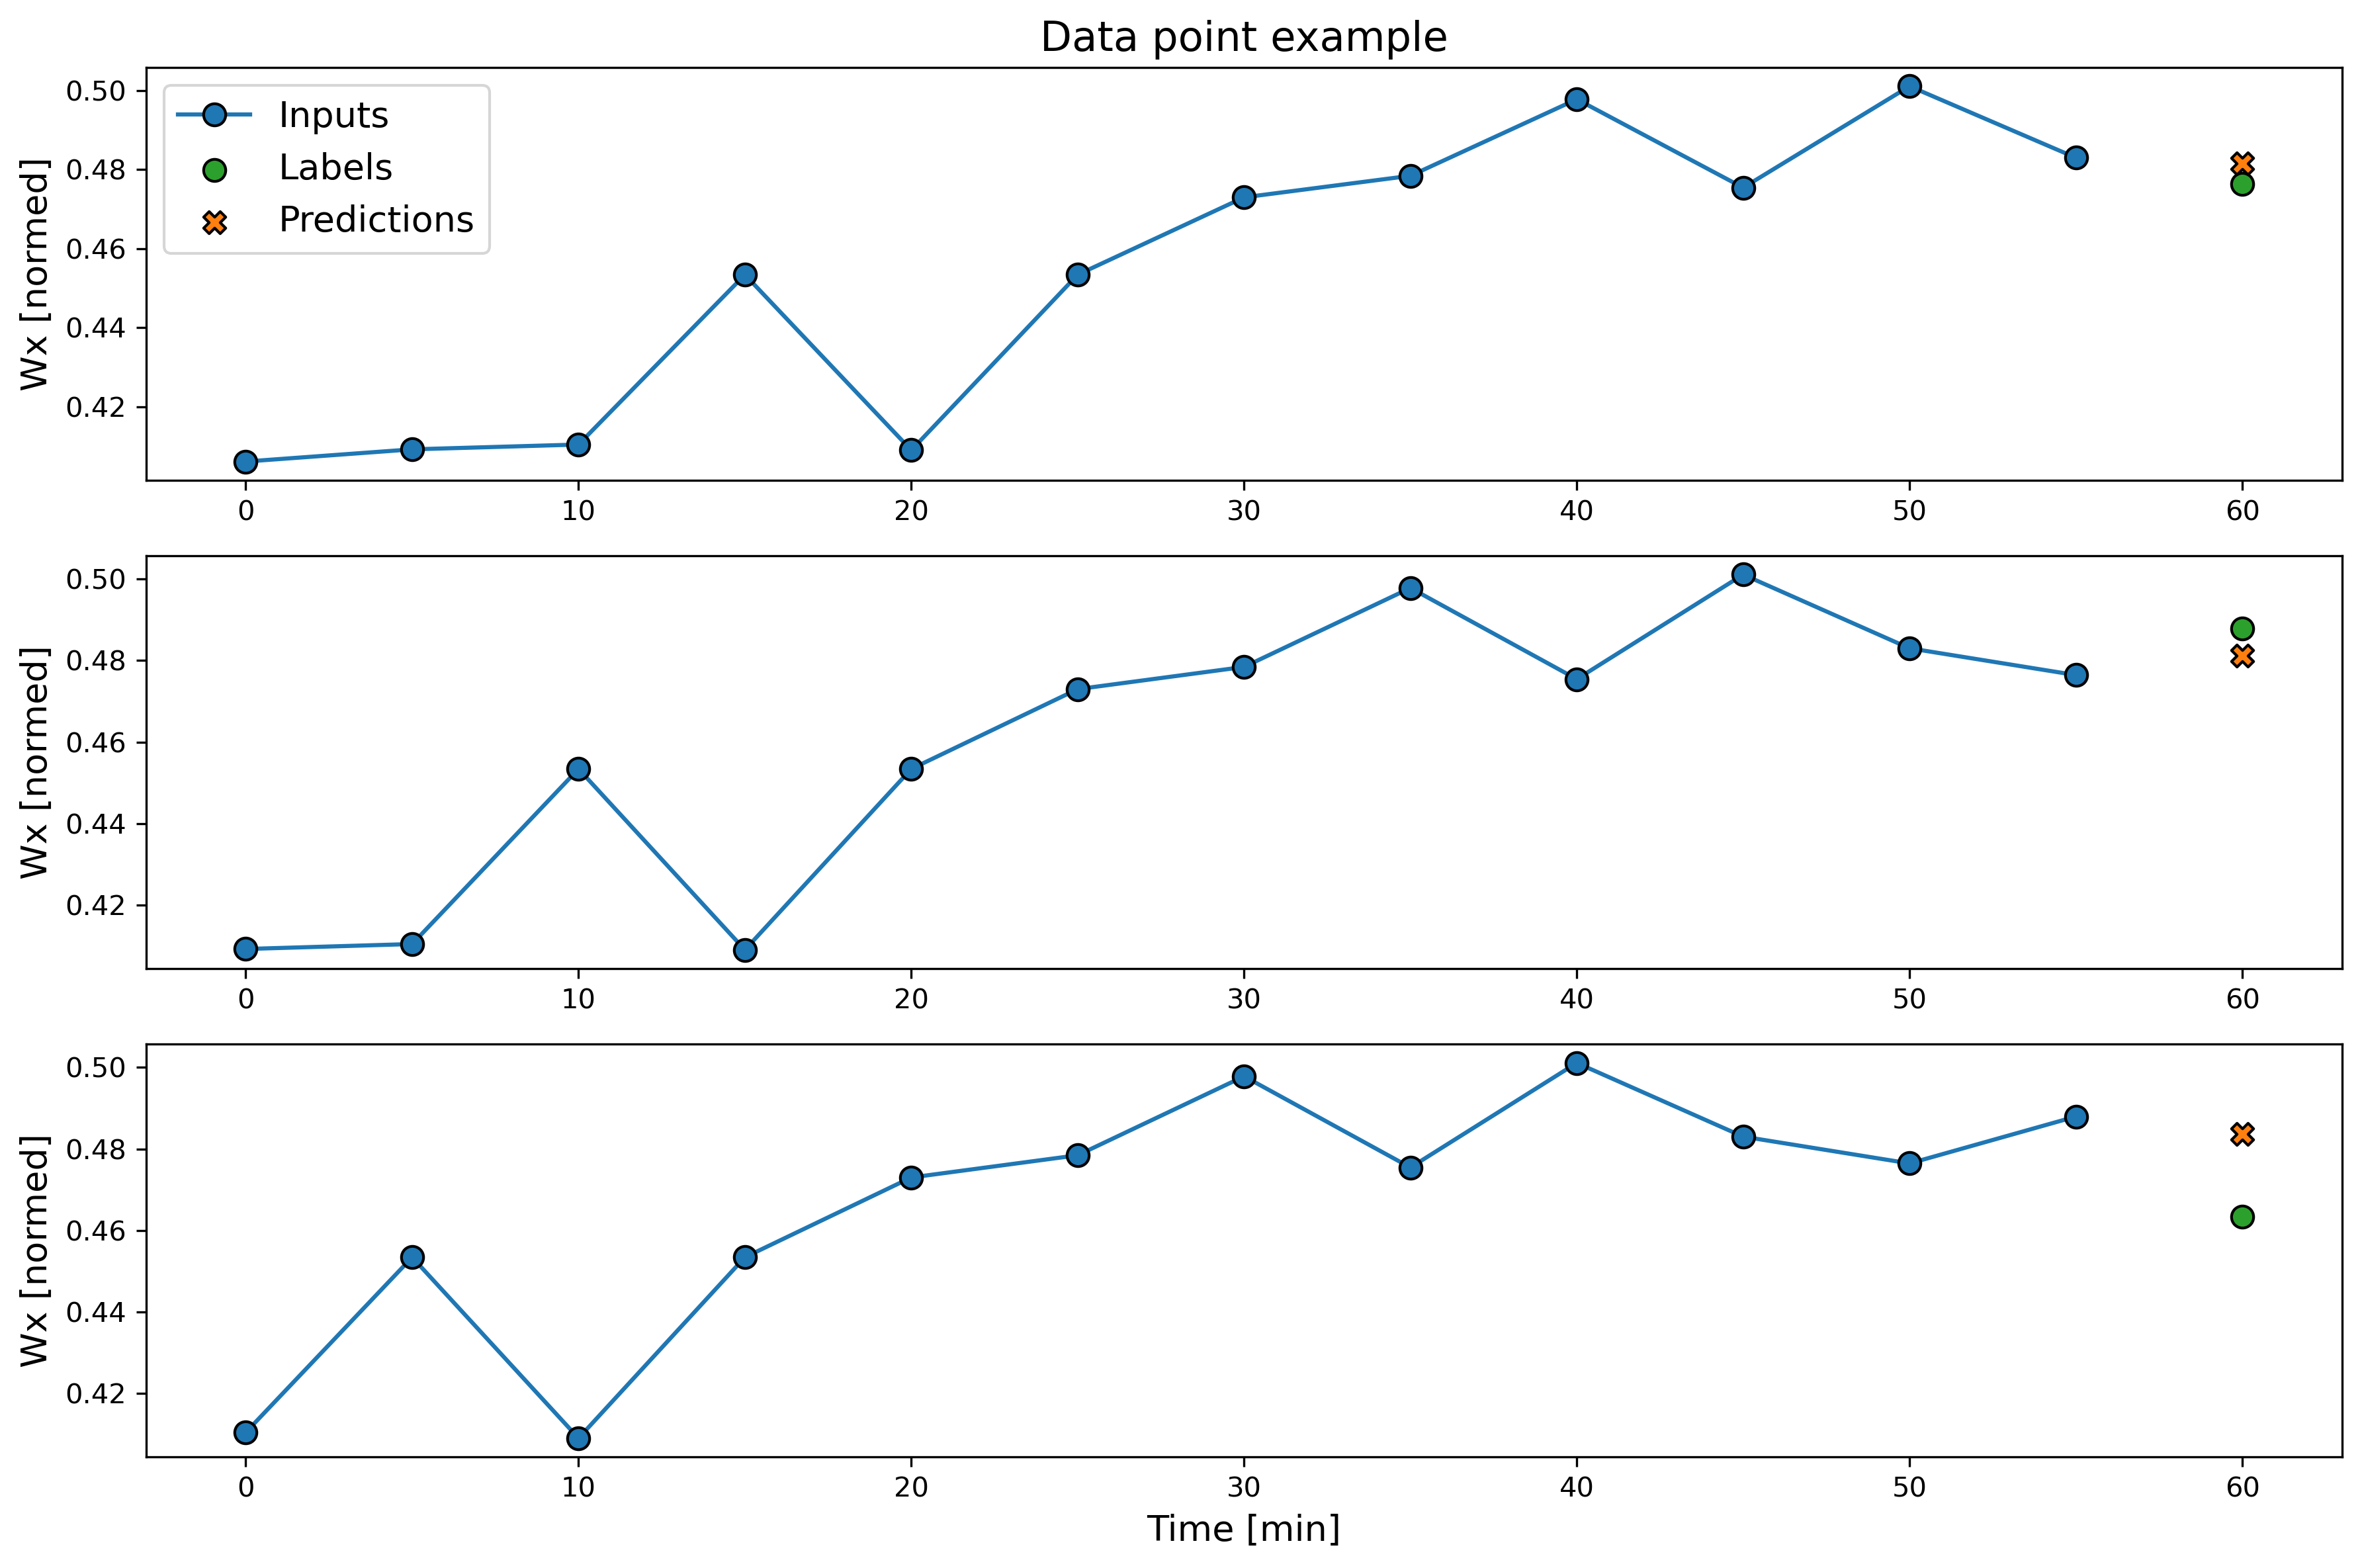

In [158]:
multi_window_wx.plot(plot_col='Wx', model=model_wx)

Si può anche eseguire un rapido controllo della shape degli input e dei label di un intero batch:

In [26]:
for example_inputs, example_labels in multi_window_wx.train.take(1):
        print(f'Inputs shape (batch, time_steps, features): {example_inputs.shape}')
        print(f'Labels shape (batch, time_steps, features): {example_labels.shape}')

Inputs shape (batch, time_steps, features): (32, 12, 14)
Labels shape (batch, time_steps, features): (32, 1, 1)


## Modello

Ho deciso di optare per l'utilizzo di una rete neurale ricorsiva(RNN). Si tratta di [semplice rete neurale ricorsiva](https://keras.io/api/layers/recurrent_layers/simple_rnn/)
```python 
tf.keras.layers.SimpleRNN
```
Ovviamente esistono modelli molto più performanti sia in termini di predizione che allenamento ma ho deciso di considerare il modello forse più semplice per capire se fosse comunque in grado di fornire predizioni adeguate e in che termini.


### SimpleRNN

Le reti neurali ricorrenti si prestano bene nei campi del *forecasting* di serie temporali e nel *natual language processing* in quanto contemplano una componente di 'Memoria', sono cioè in grado di effettuare la predizione propagando in parte la informazione raccolta dall'input in posizione `k` per processare l'input in posizione 'k+1'. 



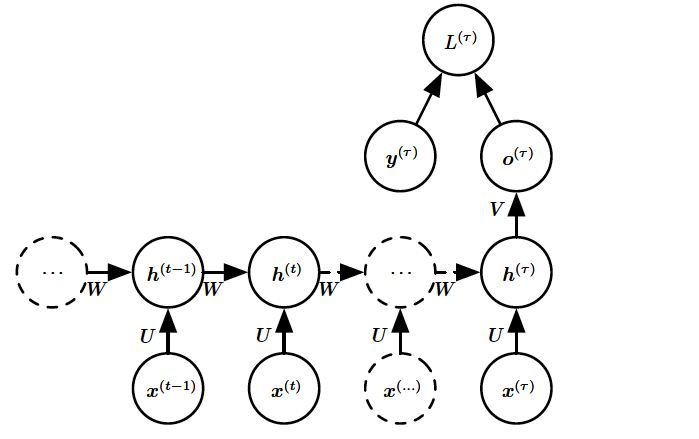

In [47]:
image_path = 'Screenshot 2023-09-24 at 21.05.43.png'  
Image(filename=image_path)

Lo schema, preso dal libro di ***Goodfellow*** è molto esplicativo per un singolo neurone. In sintesi le operazioni che vengono esuguite sono:
- $a^{(t)} = b + Wh^{(t-1)} + Ux^{(t)}$
- $h^{(t)} = \sigma{(a^{(t)})}$
- $o^{(\tau)}=c+Vh^{(\tau)}$

Dove $b,c$ sono bias, $W,U,V$ sono matrici di pesi mentre $\sigma$ indica una generica funzione di attivazione non lineare.
$o^{(\tau)}$ è la predizione che viene fatta al tempo finale $\tau$ e che viene confrontata con il label $y^{(\tau)}$ mediante una funzione costo $L$.
Ovviamente bisogna considerare che quelli citati sono matrici/vettori la cui dimensionalità dipende dal numero di features e dal numero di neuroni che vengono effettivamente utilizzati.
Successivamente viene applicato un **layer di droput** che mette a zero in maniera random con probabilità p l'output della rete ricorsiva. Nonostante possa sembrare una pratica piuttosto drastica si rivela molto efficace per prevenire l'overfitting del modello nel corso del training.
Infine ho applicato un **layer dense** che produce la predizione di una singola feature.

Per quanto riguarda l'implementazione vera e propria, anche in questo caso ho scritto una classe che facesso uso di `Keras` e della classe `WindowGenerator()` precedentemente implementata.

Il seguente codice (commentato in dettaglio) contiene i metodi:
```Python

class Model():
    
    def __init__(...):
        
        """Inizializza la classe ed i suoi data membri"""
    def RNN(...):
        """ Costruisce il modello RNN utilizzando sia il SimpleRNN layer che un layer dense per le predizioni"""
    def compile(...):
        """inizializza l'ottimizzatore, la loss e le metriche aggiuntive di allenamento"""
    def compile_and_fit(...):
        """Compila ed effettua il training del modello """
    def plot_history(...):
        """Plotta il training"""
    def predict(...):
        """Effettua una predizione"""
    ...
```

In [77]:
class Model():

    def __init__(self, window):
        
        """
        Inizializzazione.
        Inputs:
        - self
        - window: oggetto tipo `WindowGenerator`
        """

        self.multi_val_performance = {}
        self.multi_performance = {}
        self.window = window
    
    def RNN(self,model_name,number_of_features, batch_size=None, IN_STEPS=12):
        
        """
        Costruisce il modello.
        Inputs:
        - self
        - `str` model name
        - `int` number_of_features: # features usate
        - `int` batch_size
        - `int` IN_STEP lunghezza della finestra di training
        """
        
        #Batchsize = None means whatsoever
        hidden_neurons = 100
        
        model = tf.keras.Sequential([
            
            tf.keras.layers.SimpleRNN(hidden_neurons, input_shape= (IN_STEPS, number_of_features), return_sequences=False, name = 'RNN'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid', name="dense")
            
        ])
        
        self.model = model
        self.model_name = model_name

    def compile(self):
        
        """ Compila il modello"""

        self.model.compile(loss=tf.keras.losses.MeanSquaredError(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=[tf.keras.metrics.MeanAbsoluteError()])

    def compile_and_fit(self, Earlystopping=True, TensorBoard=True, epochs=20, patience=5, verbose=0):
        
        """ Compila e fitta il modello. E' stato aggiunto il callback di Earlystopping"""
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./log')

        print('\n\n')
        print('Model name', self.model_name)

        self.compile()

        callbacks=[]

        if (TensorBoard):
                callbacks.append(tensorboard_callback)
                print('Tensorboard callback available')
                
        if (Earlystopping):
                callbacks.append(early_stopping)
                print('Doing early stopping with patience =',patience)

        print('\n')

        history = self.model.fit(self.window.train, epochs=epochs, validation_data=self.window.val, callbacks=callbacks, verbose=verbose)
        
        self.history = history
        
        return history
    
    def plot_history(self):
        
        plt.figure(figsize=(10,4), dpi=300)

        plt.subplot(1,2,1)
        plt.plot(self.history.history['loss'], label='Training')
        plt.plot(self.history.history['val_loss'], label='Validation')
        plt.ylabel('Loss', fontsize=13)
        plt.xlabel('Epoch', fontsize=13)
        plt.legend(fontsize=13)
        plt.title('Loss', fontsize=16)

        plt.subplot(1,2,2)
        plt.plot(self.history.history['mean_absolute_error'], label='Training')
        plt.plot(self.history.history['val_mean_absolute_error'], label='Validation')
        plt.ylabel('log MAE', fontsize=13)
        plt.yscale('log')
        plt.xlabel('Epoch', fontsize=13)
        plt.legend(fontsize=13)
        plt.title('MAE', fontsize=16)

        plt.tight_layout()
        plt.suptitle(f'{self.model_name} training', fontsize=16)
        plt.show()
    
    def predict(self, inputs):
        return self.model(inputs)

Qui sotto riporto quelli che sono gli effettivi parametri dei modello che ho utilizzato, ottenuti con la util di Keras:

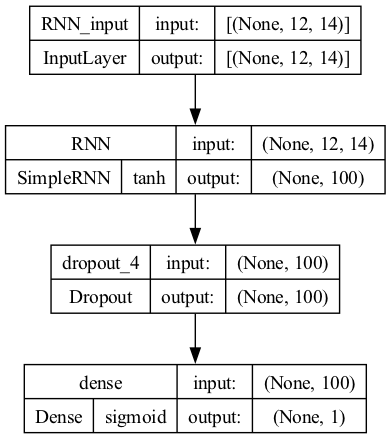

In [159]:
#Simple RNN
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model_wx.model, to_file=dot_img_file, show_shapes=True, dpi=100, expand_nested=True,show_layer_activations=True)

## Training

In [160]:
model_wx = Model(multi_window_wx)
model_wx.RNN(IN_STEPS=12, number_of_features=14,model_name='RNN_wx')
model_wx.model.load_weights('weightsRNN_wx.h5')
print(model_wx.model.summary())
model_wx.compile_and_fit(epochs=100, verbose=0)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN (SimpleRNN)             (None, 100)               11500     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________
None



Model name RNN_wx
Tensorboard callback available
Doing early stopping with patience = 5




2023-09-25 07:17:57.577360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-25 07:20:55.285226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


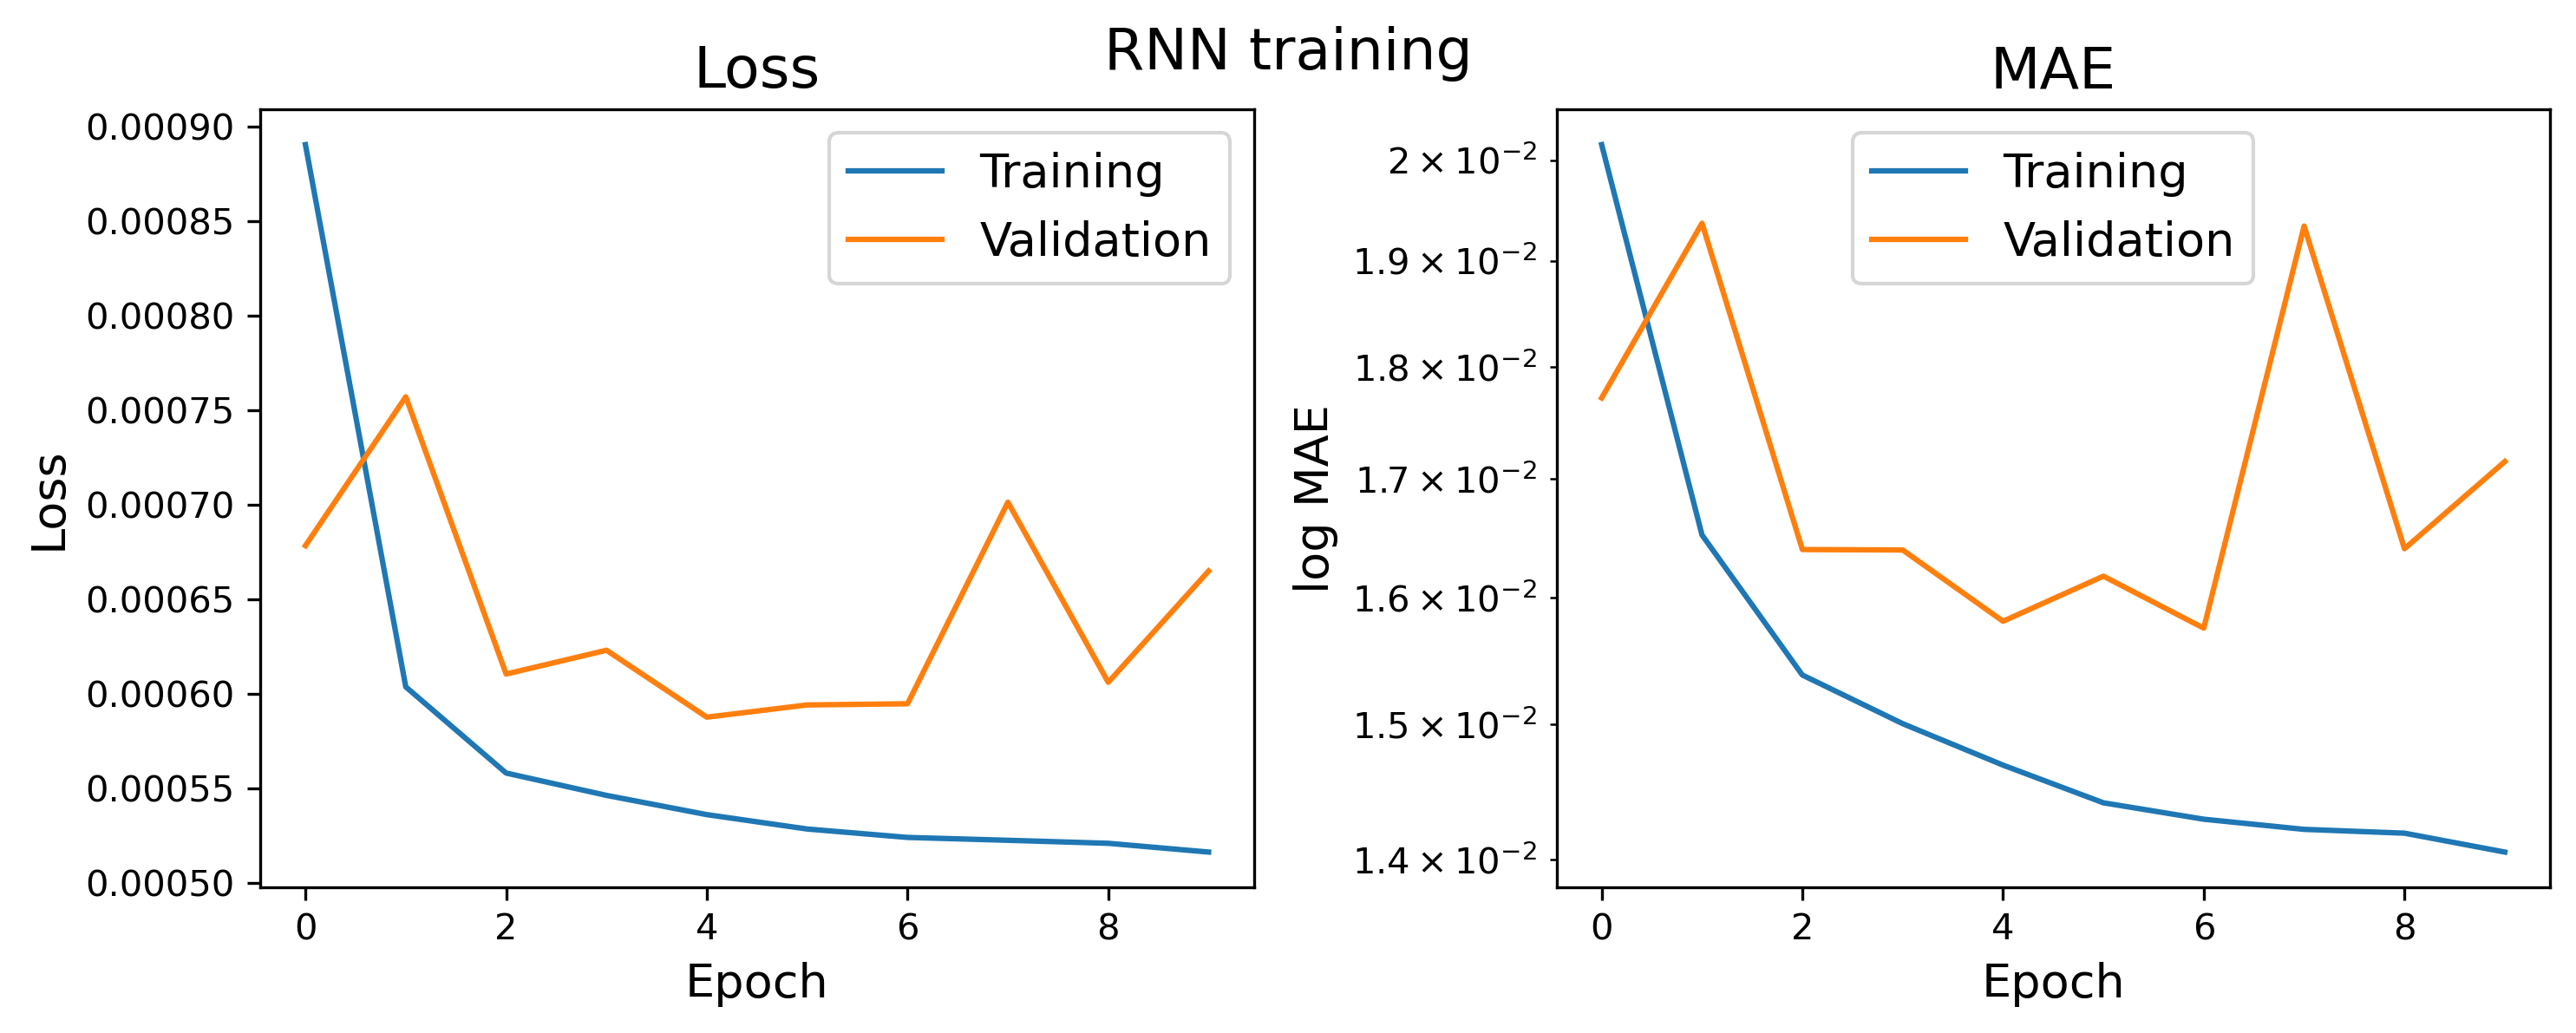

In [53]:
model_wx.plot_history()
model_wx.model.save_weights('weightsRNN_wx.h5')

Salvo dunque le predizioni su tutto il test set di Wx:

In [66]:
labels=[]
predictions=[]

In [62]:
def get_test_set_predictions(n_features, window_class, model):
    y_labels = np.empty((0, n_features))  
    y_predicted = np.empty((0, n_features))
    
    for batch in window_class.unshuffled_test:
        inputs, labels = batch

        predictions = model.predict(inputs)  

        labels = tf.squeeze(labels, axis=1)

        y_labels = np.vstack((y_labels, labels.numpy()))
        y_predicted = np.vstack((y_predicted, predictions.numpy()))
    return y_labels, y_predicted

In [67]:
RNN_test_labels_wx, RNN_test_predictions_wx = get_test_set_predictions(1, multi_window_wx, model_wx)
labels.append(RNN_test_labels_wx)
predictions.append(RNN_test_predictions_wx)

Vediamo ora cosa fare per la componente y del vento. Poichè i dati sono simili si può provare a vedere come si comportano i modelli già allenati per la componente x. Per studiare questo comportamento è necessario dotarli della nuova finestra wy:

In [162]:
IN_STEPS = 12
OUT_STEPS = 1
prediction_labels = ['Wy']
multi_window_wy = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               test_df=test_df,
                               val_df = val_df,
                               label_columns=prediction_labels,
                               batch_size=32)

In [164]:
model_wx.window = multi_window_wy

Possiamo quindi valutare la performance di questo modello, per come già allenato, sul nuovo test set relativo alla componente 'Wy':

In [165]:
print(model_wx.model.evaluate(model_wx.window.test))

547/547 [==============================] - 7s 13ms/step - loss: 0.0075 - mean_absolute_error: 0.0651
[0.007481026463210583, 0.06506887078285217]


Nonostante i dati wx e wy siano simili, le affinità non sono tali da mostrare una performance ottimale. Conviene quindi allenare il modello anche per questi dati.

In [168]:
model_wy = Model(multi_window_wy)
model_wy.RNN(IN_STEPS=12, number_of_features=14,model_name='RNN_wy')
model_wy.model.load_weights('weightsRNN_wy.h5')
print(model_wy.model.summary())
model_wy.compile_and_fit(epochs=100, verbose=0)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN (SimpleRNN)             (None, 100)               11500     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________
None



Model name RNN_wy
Tensorboard callback available
Doing early stopping with patience = 5




2023-09-25 07:23:34.713934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-25 07:26:36.680294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [926]:
model_wy.model.save_weights('weightsRNN_wy.h5')

In [87]:
RNN_test_labels_wy, RNN_test_predictions_wy = get_test_set_predictions(1, multi_window_wy, model_wy)
labels.append(RNN_test_labels_wy)
predictions.append(RNN_test_predictions_wy)

Stessa cosa per gust:

In [75]:
IN_STEPS = 12
OUT_STEPS = 1
prediction_labels = ['Gust']
multi_window_gust = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               test_df=test_df,
                               val_df = val_df,
                               label_columns=prediction_labels,
                               batch_size=32)

In [170]:
model_gust = Model(multi_window_gust)
model_gust.RNN(IN_STEPS=12, number_of_features=14,model_name='RNN_gust')
model_gust.model.load_weights('weightsRNN_gust.h5')
print(model_gust.model.summary())
model_gust.compile_and_fit(epochs=100, verbose=0)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN (SimpleRNN)             (None, 100)               11500     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________
None



Model name RNN_gust
Tensorboard callback available
Doing early stopping with patience = 5




2023-09-25 07:28:03.668724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-25 07:31:08.976976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [940]:
model_gust.model.save_weights('weightsRNN_gust.h5')

In [88]:
RNN_test_labels_gust, RNN_test_predictions_gust = get_test_set_predictions(1, multi_window_gust, model_gust)
labels.append(RNN_test_labels_gust)
predictions.append(RNN_test_predictions_gust)

## Performance e visualizzazioni

Di seguito riporto le predizioni sull'intero test set per le tre componenti

In [92]:
def plot_predictions_ALL(labels, pred):

    plt.figure(figsize=(10,8), dpi=300)
    
    plt.subplot(3,1,1)
    
    #Plot the labels
    plt.plot(labels[0][:,0], c='tab:green', label='Labels')
    
    #Plot the models predictions
    plt.plot(pred[0][:,0], c='tab:purple', label='RNN')
    #plt.plot(pred_rnn[:,0], c='cornflowerblue', label='RNN')


    plt.ylabel('Normed Wx', fontsize=13)
    plt.xlabel('Time [min]', fontsize=13)
    plt.grid()
    plt.title('Model predictions Wx', fontsize=13)
    plt.legend(fontsize=13)
    
    plt.subplot(3,1,2)
    
    #Plot the labels
    plt.plot(labels[1][:,0], c='tab:green', label='Labels')
    
    #Plot the models predictions
    plt.plot(pred[1][:,0], c='tab:purple', label='RNN')
    #plt.plot(pred_rnn[:,0], c='cornflowerblue', label='RNN')


    plt.ylabel('Normed Wy', fontsize=13)
    plt.xlabel('Time [min]', fontsize=13)
    plt.grid()
    plt.title('Model predictions Wy', fontsize=13)
    plt.legend(fontsize=13)
    
    plt.subplot(3,1,3)
    
    #Plot the labels
    plt.plot(labels[2][:,0], c='tab:green', label='Labels')
    
    #Plot the models predictions
    plt.plot(pred[2][:,0], c='tab:purple', label='RNN')
    #plt.plot(pred_rnn[:,0], c='cornflowerblue', label='RNN')


    plt.ylabel('Normed Gust', fontsize=13)
    plt.xlabel('Time [min]', fontsize=13)
    plt.grid()
    plt.title('Model predictions Gust', fontsize=13)
    plt.legend(fontsize=13)
    

    plt.tight_layout()
    plt.show()

In [95]:
#Deviations
diffRNN_wx = RNN_test_labels_wx - RNN_test_predictions_wx
diffRNN_wy = RNN_test_labels_wy - RNN_test_predictions_wy
diffRNN_gust = RNN_test_labels_gust - RNN_test_predictions_gust

#Performances
performanceRNN_gust= model_gust.model.evaluate(model_gust.window.test, verbose=0)
performanceRNN_wy= model_wy.model.evaluate(model_wy.window.test, verbose=0)
performanceRNN_wx = model_wx.model.evaluate(model_wx.window.test, verbose=0)

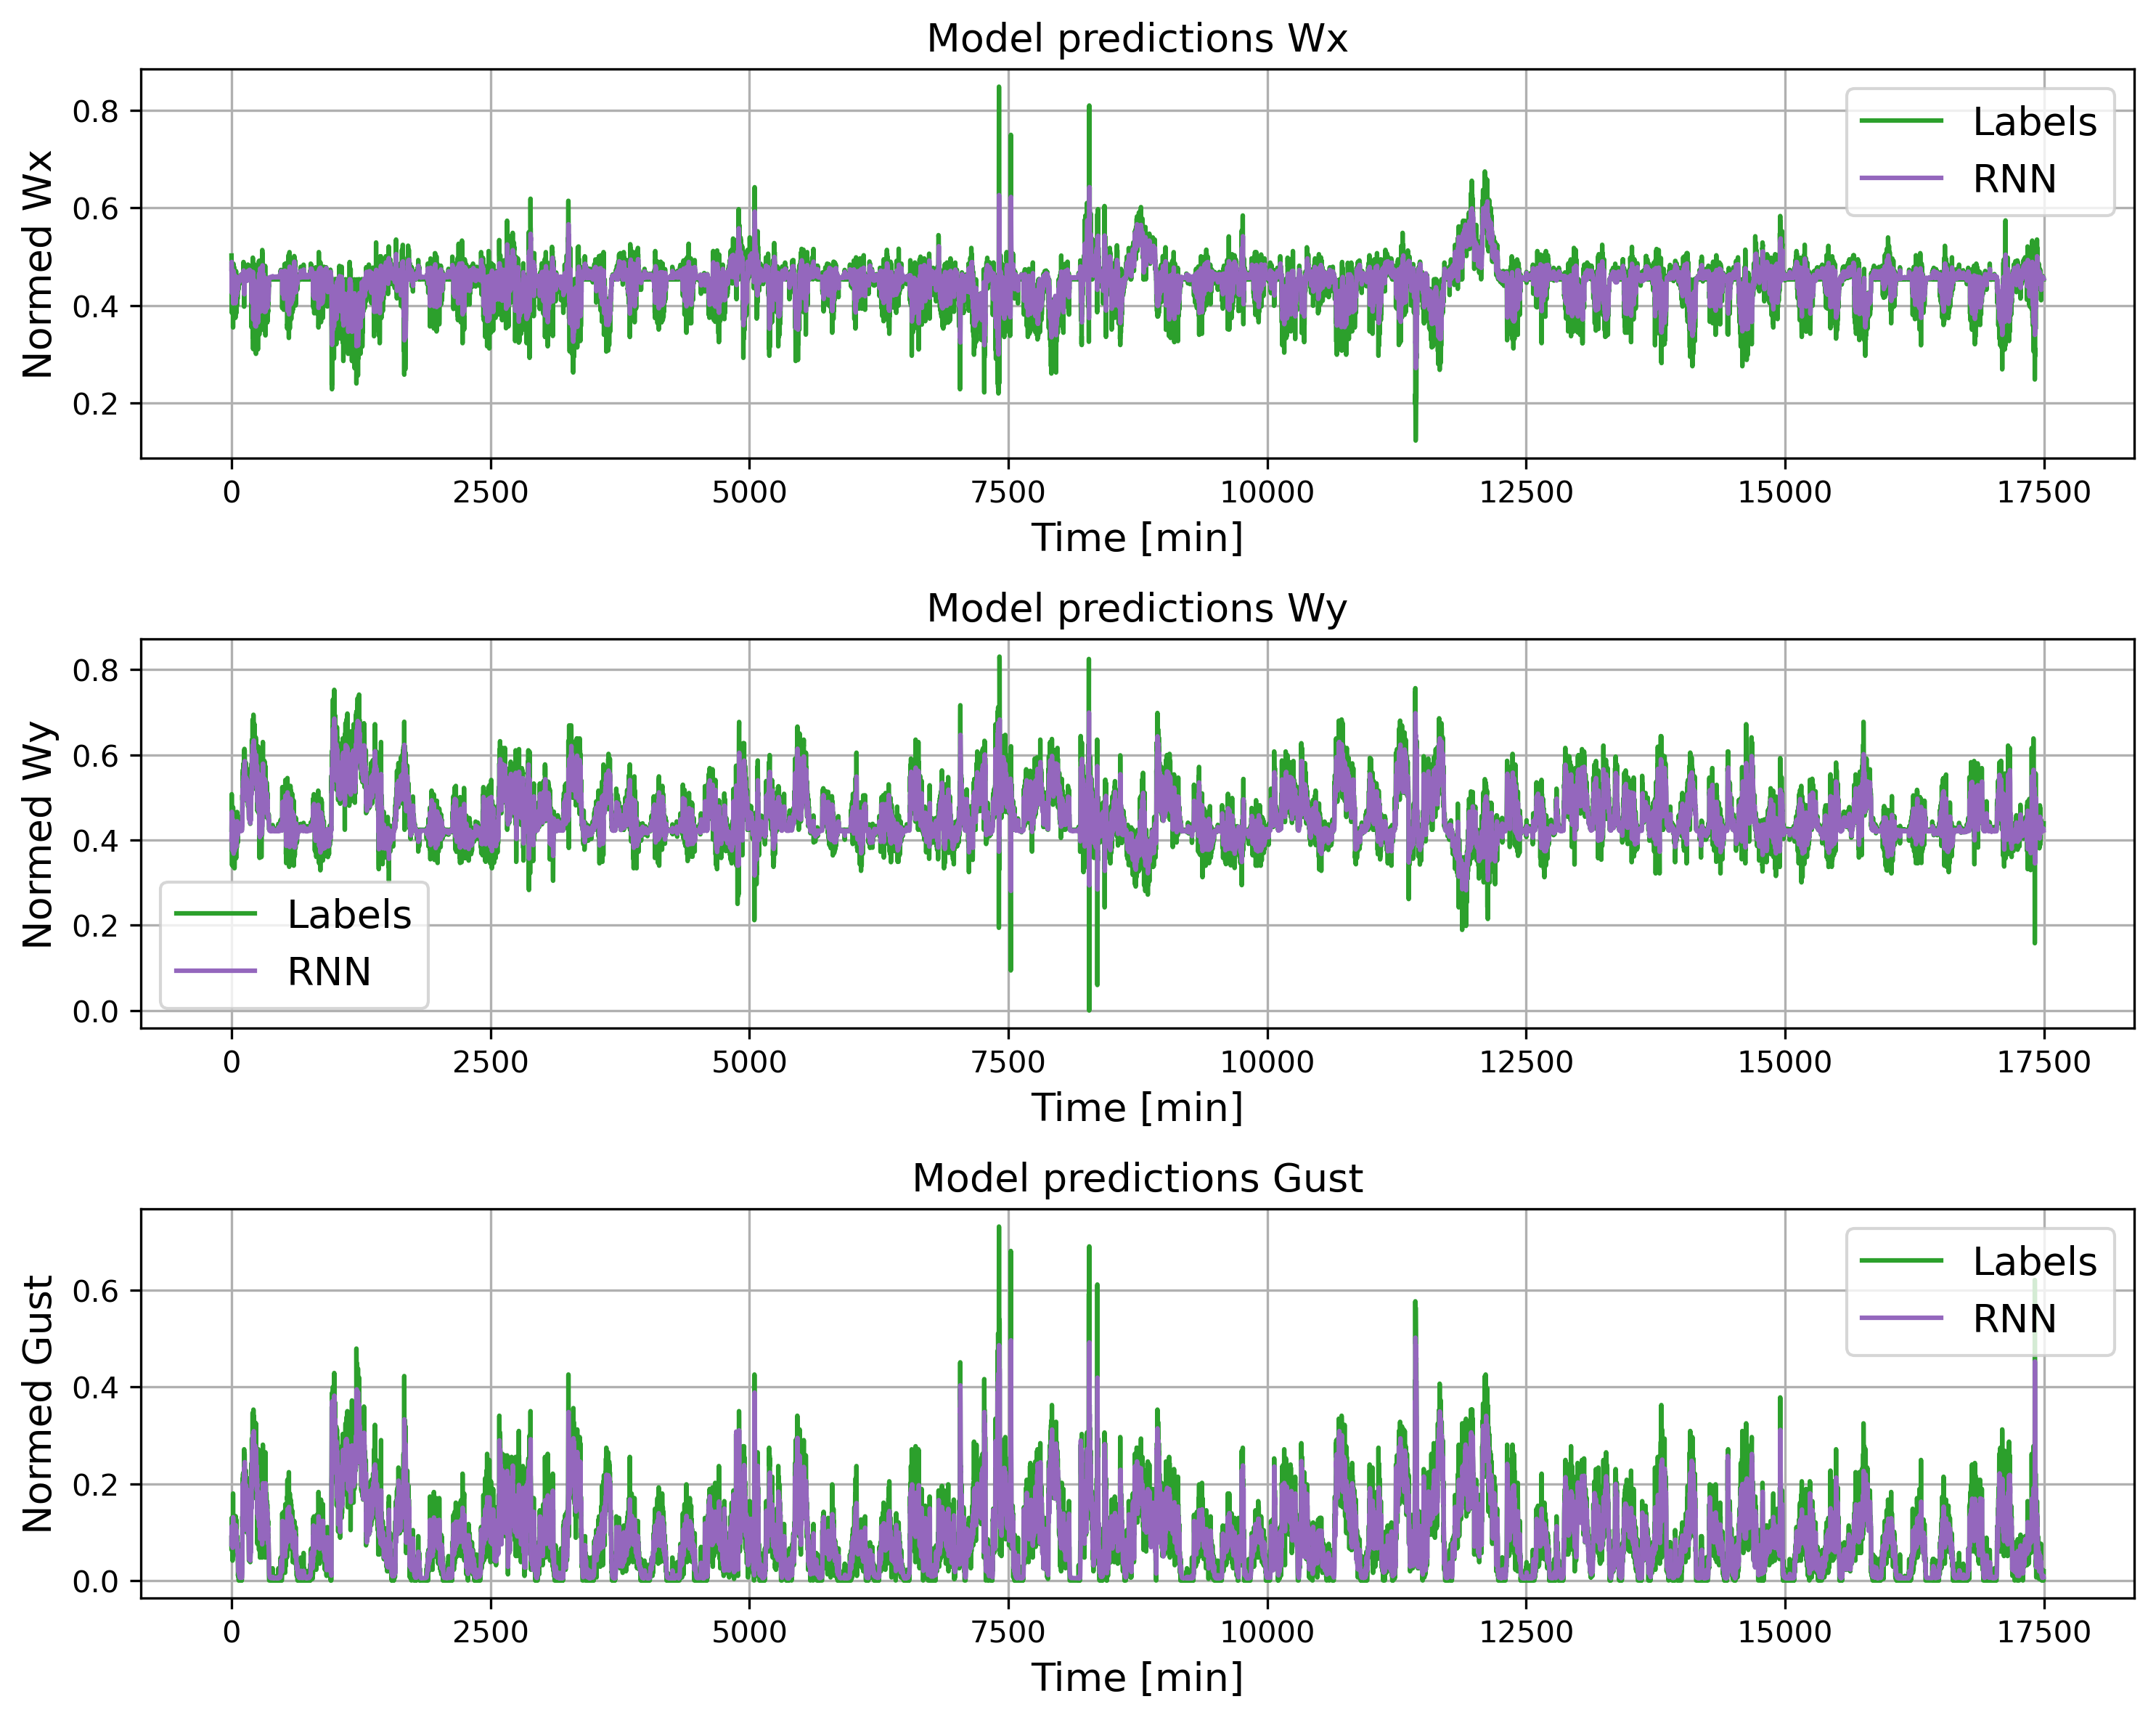

In [93]:
plot_predictions_ALL(labels,predictions)

Dal precedente plot non siamo in grado di fare osservazioni di tipo quantitativo. Tuttavia, possiamo vedere in genere questo semplice modello sia in grado di riprodurre i dati osservati, sopratutto quando le variazioni non sono troppo repentine e drastiche.
Possiamo anche osservare le deviazioni delle predizioni dai labels:

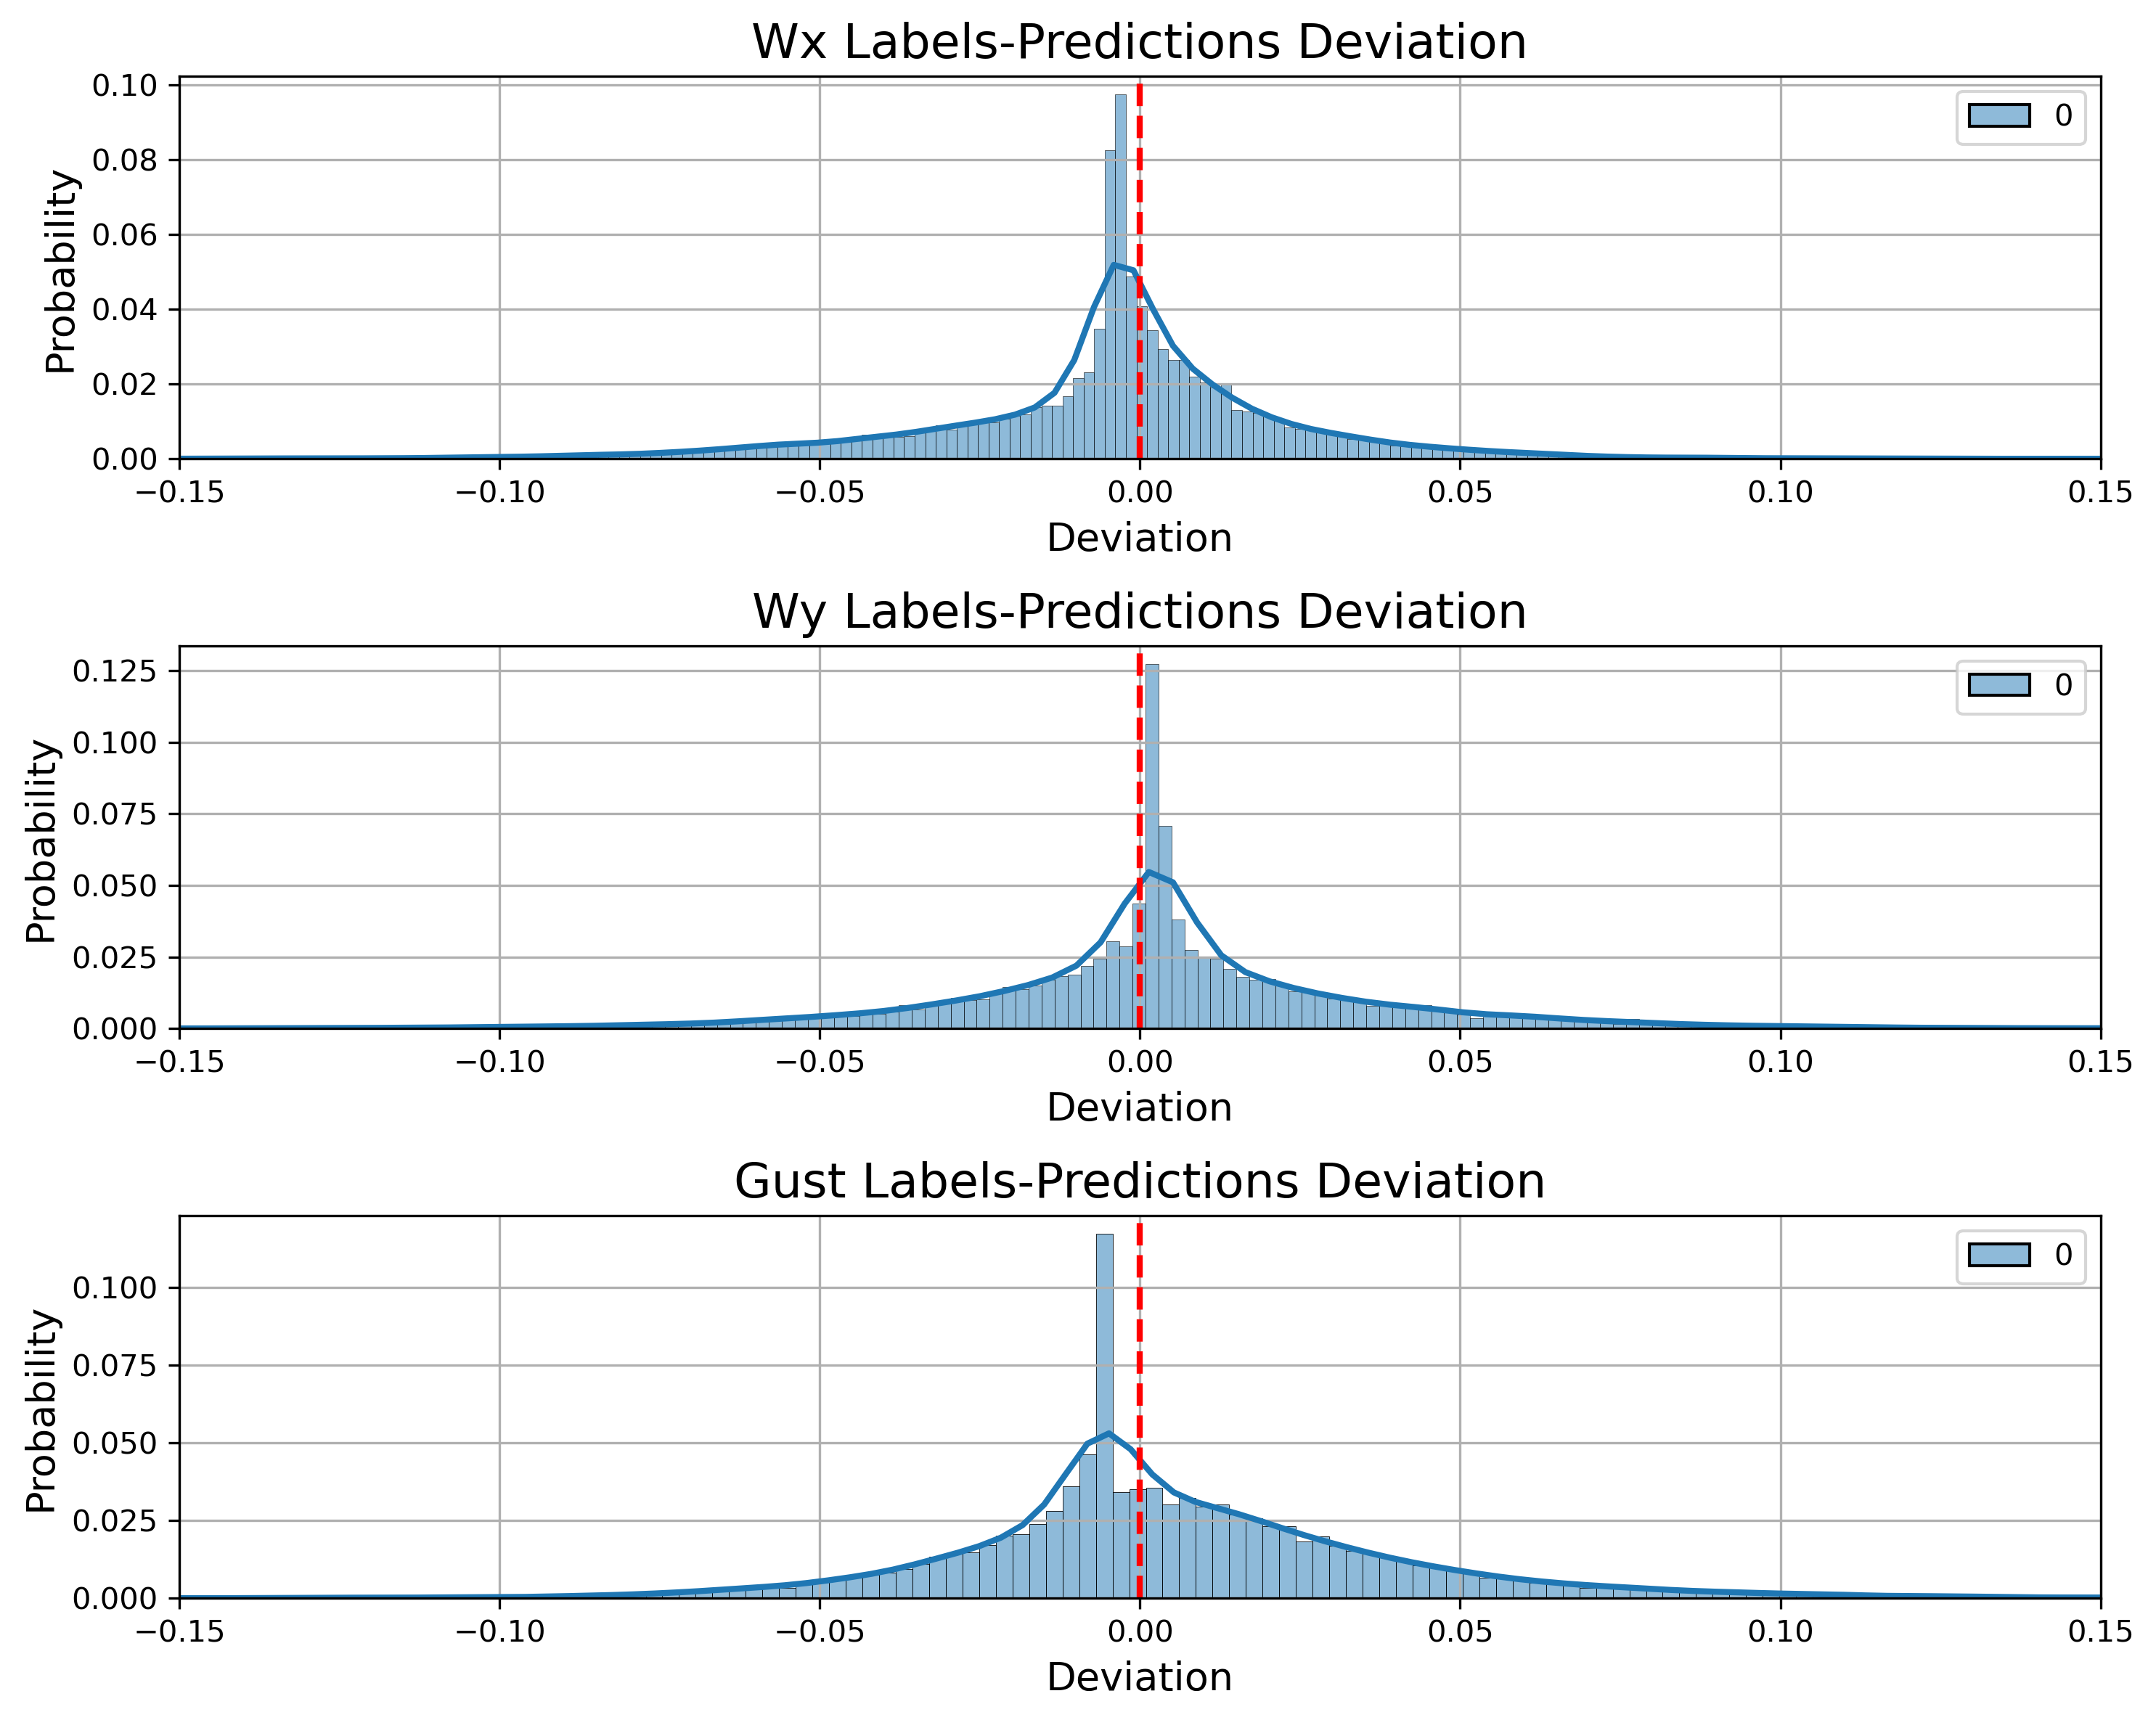

In [116]:
# Create subplots with three rows (one for each histogram)
fig, axs = plt.subplots(3, 1, figsize=(10, 8), dpi=300)

# Plot separate histograms for 'Wx', 'Wy', and 'Gust' on different axes
histplot_wx = sns.histplot(diffRNN_wx,stat='probability', ax=axs[0], kde=True, line_kws={'lw': '2'})
histplot_wy = sns.histplot(diffRNN_wy,stat='probability', ax=axs[1], kde=True, line_kws={'lw': '2'})
histplot_gust = sns.histplot(diffRNN_gust,stat='probability', ax=axs[2], kde=True, line_kws={'lw': '2'})

# Customize each subplot
for ax, variable in zip(axs, ['Wx', 'Wy', 'Gust']):
    ax.axvline(0, color='red', ls='--', lw=2)
    ax.set_ylabel(ax.get_ylabel(), fontsize='13')
    ax.set_xlabel('Deviation', fontsize=13)
    ax.set_title(f'{variable} Labels-Predictions Deviation', fontsize=16)
    ax.set_xlim(-0.15, 0.15)
    ax.grid()

plt.tight_layout()

In [177]:
print(f'Wx: deviations from label std: {np.asarray(diffRNN_wx).std():.4f}')
print(f'Wy: deviations from label std: {np.asarray(diffRNN_wy).std():.4f}')
print(f'Gust: deviations from label std: {np.asarray(diffRNN_gust).std():.4f}')

Wx: deviations from label sparsity: 0.0280
Wy: deviations from label sparsity: 0.0333
Gust: deviations from label sparsity: 0.0353


Vediamo come le predizioni più frequenti, per tutte e tre le features, hanno una deviazione dal valore reale inferiore all'1% con una deviazione standard massima per le 3 componenti di 0.0353.
Possiamo anche osservare qui sotto che il 90% delle osservazioni ha mostrato un errore sotto il 5%

In [196]:
print(f'Wx: probability of having an error < 5%: {np.sum(np.abs(diffRNN_wx) < 0.05) / len(diffRNN_wx):.4f}%')
print(f'Wy: probability of having an error < 5%: {np.sum(np.abs(diffRNN_wy) < 0.05) / len(diffRNN_wy):.4f}%')
print(f'Gust: probability of having an error < 5%: {np.sum(np.abs(diffRNN_gust) < 0.05) / len(diffRNN_gust):.4f}%')

Wx: probability of having an error < 5%: 0.9090%
Wy: probability of having an error < 5%: 0.8784%
Gust: probability of having an error < 5%: 0.8685%


Di seguito mostro le performance (in termini di MSE e MAE) calcolate su tutto il test set e gli istogrammi delle deviazioni dai label per le tre componenti.

Model performances, *[Wy]* prediction:
[Wx] Total MSE: 0.0008, total MAE: 0.0187
[Wy] Total MSE: 0.0011, total MAE: 0.0220
[Gust] Total MSE: 0.0013, total MAE: 0.0247


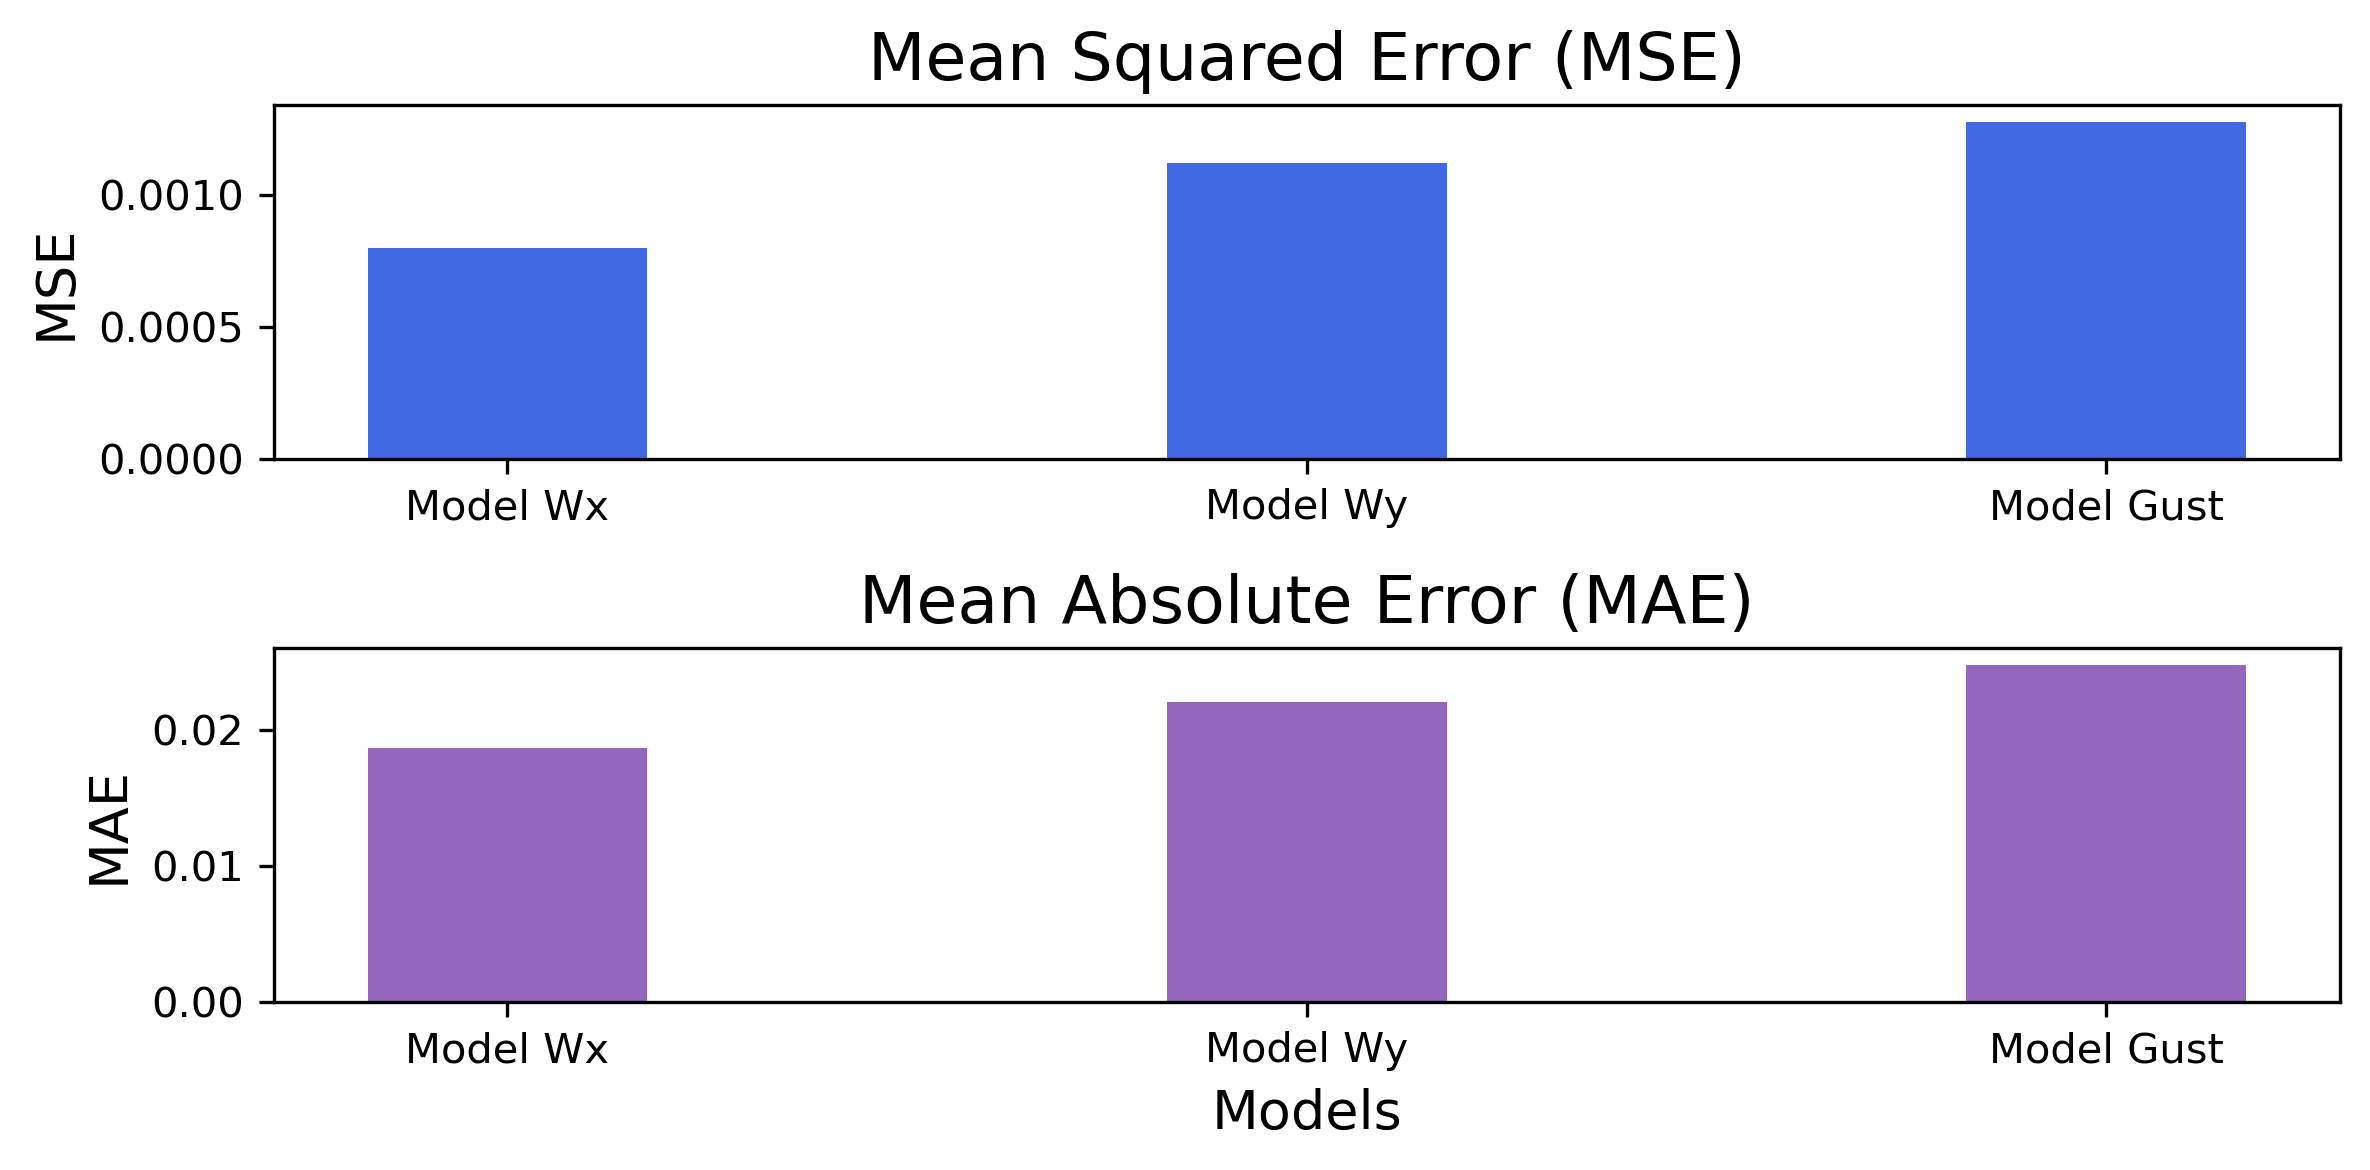

In [110]:
import matplotlib.pyplot as plt

# Performances bar plot for MSE
mse_values = [performanceRNN_wx[0], performanceRNN_wy[0], performanceRNN_gust[0]]

# Performances bar plot for MAE
mae_values = [performanceRNN_wx[1], performanceRNN_wy[1], performanceRNN_gust[1]]

# Model names
model_names = ['Model Wx', 'Model Wy', 'Model Gust']

# X positions for the bars
x = range(len(model_names))

# Bar width
bar_width = 0.35

# Create a figure and two subplots for MSE and MAE
fig, axs = plt.subplots(2, 1, figsize=(8, 4), dpi=300)

# Create bar plots for MSE
axs[0].bar(x, mse_values, bar_width, align='center', color='royalblue')
axs[0].set_xticks([i for i in x])
axs[0].set_xticklabels(model_names)
axs[0].set_ylabel('MSE', fontsize=13)
axs[0].set_title('Mean Squared Error (MSE)', fontsize=16)

# Create bar plots for MAE
axs[1].bar(x, mae_values, bar_width, align='center', color='tab:purple')
axs[1].set_xticks([i for i in x])
axs[1].set_xticklabels(model_names)
axs[1].set_xlabel('Models', fontsize=13)
axs[1].set_ylabel('MAE', fontsize=13)
axs[1].set_title('Mean Absolute Error (MAE)', fontsize=16)

# Adjust the layout
plt.tight_layout()

print('='*43)
print('Model performances, *[Wy]* prediction:')
print(f'[Wx] Total MSE: {performanceRNN_wx[0]:.4f}, total MAE: {performanceRNN_wx[1]:.4f}')
print(f'[Wy] Total MSE: {performanceRNN_wy[0]:.4f}, total MAE: {performanceRNN_wy[1]:.4f}')
print(f'[Gust] Total MSE: {performanceRNN_gust[0]:.4f}, total MAE: {performanceRNN_gust[1]:.4f}')
print('='*43)

# Show the figure
plt.show()

Di seguito si mostrano due istogrammi bidimensionali per le componenti ['Wx','Wy'] del vento, uno per le predizioni e uno relativo ai label.
Risulta interessante osservare come il modello sia in grado di riprodurre piuttosto fedelmente le medie dei dati reali mentre fatichi a predire punti che si discostano di molto dalla media, ovvero gli eventi più rari ed 'estremi'. Tuttavia è possibile notare come sia stata riprodotta la tendenza verso una particolare direzione già osservata nella fase di introduzione.

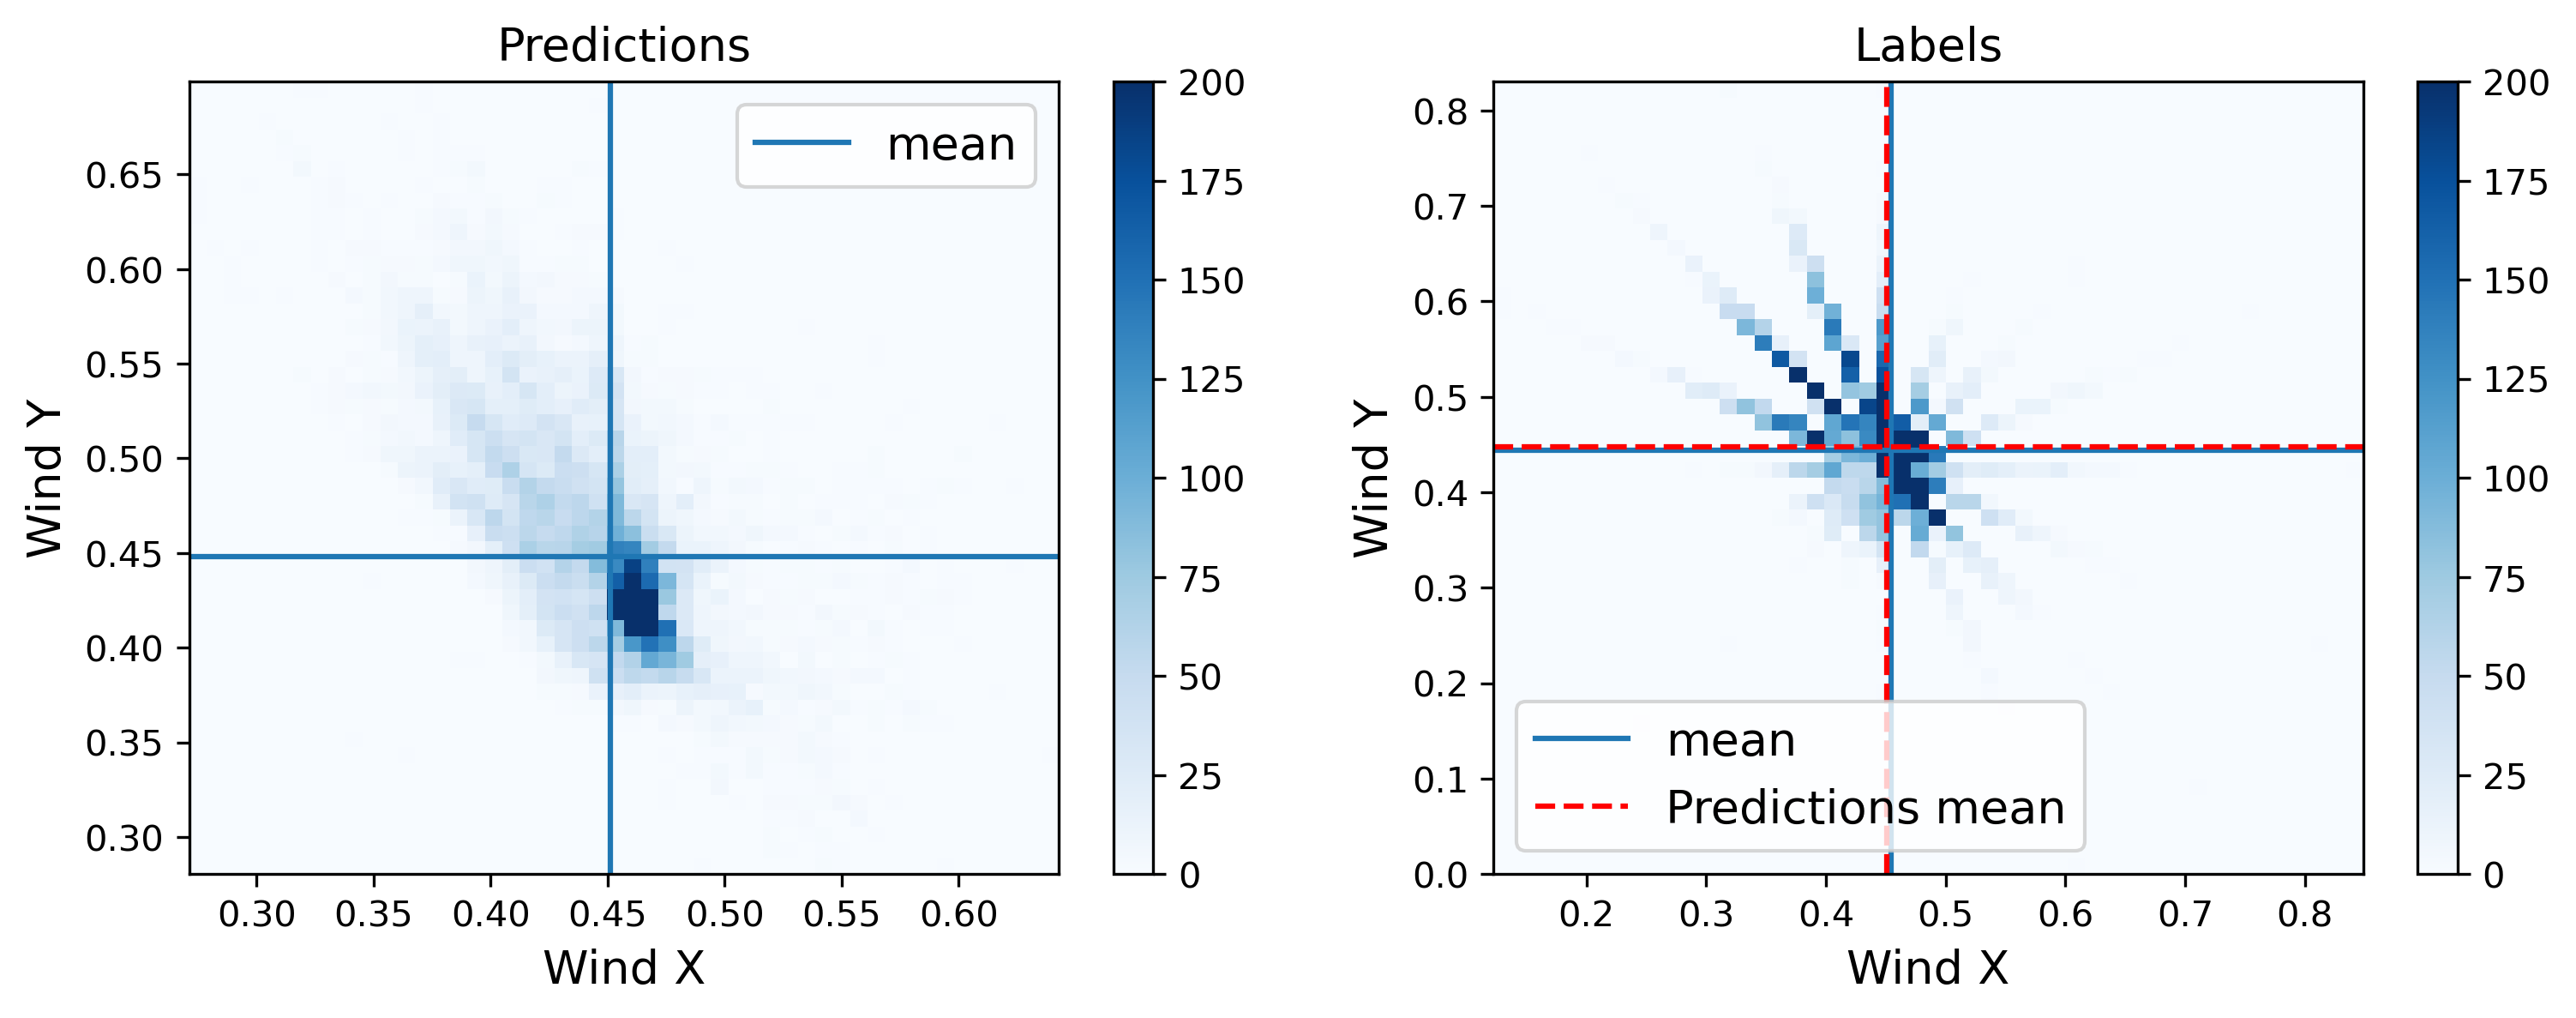

In [179]:
plt.figure(figsize=(12,4),dpi=300)
plt.subplot(1,2,1)
plt.hist2d(RNN_test_predictions_wx.squeeze(), RNN_test_predictions_wy.squeeze(), bins=(50, 50),vmax=200, cmap='Blues')
plt.axhline(np.asarray(RNN_test_predictions_wx.squeeze()).mean(), label='mean')
plt.axvline(np.asarray(RNN_test_predictions_wy.squeeze()).mean())
plt.colorbar()
plt.xlabel('Wind X', fontsize=13)
plt.ylabel('Wind Y', fontsize=13)
plt.title('Predictions', fontsize=13)
plt.legend(fontsize=13)
ax = plt.gca()
ax.axis('tight')

plt.subplot(1,2,2)
plt.hist2d(test_df['Wx'], test_df['Wy'], bins=(50, 50), vmax=200, cmap='Blues')
plt.colorbar()
plt.axhline(test_df['Wx'].mean(),label='mean')
plt.axvline(test_df['Wy'].mean())
plt.axhline(np.asarray(RNN_test_predictions_wx.squeeze()).mean(), label='Predictions mean', c='r', ls='--')
plt.axvline(np.asarray(RNN_test_predictions_wy.squeeze()).mean(), c='r', ls='--')
plt.xlabel('Wind X', fontsize=13)
plt.ylabel('Wind Y', fontsize=13)
plt.title('Labels', fontsize=13)
plt.legend(fontsize=13, loc='lower left')
ax = plt.gca()
ax.axis('tight')

plt.show()

## Conclusioni

È stato allenato con successo un modello di reti neurali ricorrenti per la predizione a corto raggio di variabili metereologiche relative al vento.
- Il fatto che la predizione tratti di un solo punto nel futuro rende inevitabilmente il compito più semplice ma si è comunque osservato che si tratta di un problema ed una situazione plausibile e che le sequenze vengono riprodotte con una precisione accettabile.
- Manca uno studio sulla lunghezza della finestra di training per capire quale sia il miglior compromesso tra lunghezza del training e precisione delle predizioni
- Volendo si poteva allenare un unico modello più grando in grado di predire tutte e 3 le features prese in considerazione contemporaneamente. Tuttavia empiricamente ho osservato che questa possibilità richiedeva tempi di allenamento troppo lunghi.
- La direzione del vento predette è un valore continuo mentre i dati in mio possesso presentavano delle direzioni discrete. Un possibile studio potrebbe considerare quindi una classificazione con una attivazione softmax.

## Bibliografia

- [Aereporto di Bresso](https://it.wikipedia.org/wiki/Aeroporto_di_Bresso)
- [Weather underground](https://www.wunderground.com/weather/LIMB)
- [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [RNNs in Keras](https://www.tensorflow.org/guide/keras/working_with_rnns)
- [Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016](https://e-hir.org/upload/pdf/hir-22-351.pdf)
- [Time series forecasting with tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series#setup)
- [Géron, Auriélien, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, II ed. O'Reilly, 2019](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [ ]:
gem_path = '/Users/matteocitterio/Documents/gemini-Project'
df1 = pd.read_csv(gem_path+'/Bresso_updated_2023-09-13 15-37.csv')

df2 = pd.read_csv(gem_path+'/Bresso_updated_2023-09-13 15-45.csv')

df3= pd.read_csv(gem_path+'/Bresso_updated_2023-09-13 15-45.csv')

df4= pd.read_csv(gem_path+'/Bresso_updated_2023-09-13 15-56.csv')

df5= pd.read_csv(gem_path+'/Bresso_updated_2023-09-13 16-27.csv')

df6= pd.read_csv(gem_path+'/Bresso_updated_2023-09-13 16-44.csv')

df6= pd.read_csv(gem_path+'/Bresso_updated_2023-09-13 16-44.csv')

df7 = pd.read_csv(gem_path+'/Bresso_updated_2023-09-14 10-43.csv')

df8 = pd.read_csv(gem_path+'/Bresso_updated_2023-09-14 11-03.csv')

df9 = pd.read_csv(gem_path+'/Bresso_updated_2023-09-14 11-27.csv')

merged_df = pd.concat([df1, df2,df3,df4,df5,df6,df7, df8, df9]).drop_duplicates(subset='Time')
#merged_df
merged_df.to_csv('./data.csv')